# BERT的Gnorm倒序裁剪

In [1]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")
d:\Pytho

In [2]:
import torch
from tqdm import tqdm
# 扩展一个剪枝后的 tensor 到 768x768
def expand_weights_to_768x768(tensor, pruned_heads):
    # 初始化列表，存储拼接的张量
    tensors_to_concat = []
    start = 0
    # 按照 pruned_heads 进行插入
    for head_idx, keep in enumerate(pruned_heads):
        if keep == 1:
            # 如果该头保留，保留原来的 64x768
            tensors_to_concat.append(tensor[start:start+64, :])
            start += 64  # 每次移动 64 行
        else:
            # 如果该头被剪掉，插入 64x768 的零矩阵
            tensors_to_concat.append(torch.zeros(64, tensor.size(1)).to(tensor.device)) 
    # 将所有部分拼接起来，得到最终的 768x768 张量
    expanded_tensor = torch.cat(tensors_to_concat, dim=0)
    return expanded_tensor
def get_QKV_norm(ds, model, tokenizer, pruned_heads, batch_size=32, device='cuda'):
    model.to(device)
    norms_Q = torch.zeros(12, 12).to(device)
    norms_K = torch.zeros(12, 12).to(device)
    norms_V = torch.zeros(12, 12).to(device)
    all_titles = ds['train']['Title']
    for layer in range(12):
        attention_layer = model.bert.encoder.layer[layer].attention.self
        heads_Q_weight = attention_layer.query.weight
        heads_K_weight = attention_layer.key.weight
        heads_V_weight = attention_layer.value.weight
        
        heads_Q_weight = heads_Q_weight.to(device)
        heads_K_weight = heads_K_weight.to(device)
        heads_V_weight = heads_V_weight.to(device)
        for i in range(0, len(all_titles), batch_size):
            batch_titles = all_titles[i:i+batch_size]
            inputs = tokenizer(batch_titles, return_tensors='pt', padding=True, truncation=True)
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            sequence_output = outputs.logits
            loss = torch.norm(sequence_output)
            model.zero_grad()
            loss.backward()
            # 处理剪枝后的权重，扩展到 768x768
            GQ  = expand_weights_to_768x768(heads_Q_weight.grad, pruned_heads[layer])
            GK  = expand_weights_to_768x768(heads_K_weight.grad, pruned_heads[layer])
            GV  = expand_weights_to_768x768(heads_V_weight.grad, pruned_heads[layer])
            tensor_Q_reshaped = GQ.view(12, 64, 768)
            tensor_K_reshaped = GK.view(12, 64, 768)
            tensor_V_reshaped = GV.view(12, 64, 768)
            l2_Q_norms = torch.norm(tensor_Q_reshaped, p=2, dim=(1, 2))
            l2_K_norms = torch.norm(tensor_K_reshaped, p=2, dim=(1, 2))
            l2_V_norms = torch.norm(tensor_V_reshaped, p=2, dim=(1, 2))
            norms_Q[layer] += l2_Q_norms
            norms_K[layer] += l2_K_norms
            norms_V[layer] += l2_V_norms
        model.zero_grad()
    norms_Q = norms_Q.cpu() / len(all_titles)
    norms_K = norms_K.cpu() / len(all_titles)
    norms_V = norms_V.cpu() / len(all_titles)
    norms = norms_Q * norms_K * norms_V
    mean_norms = norms.mean()
    std_norms = norms.std()
    normalized = (norms - mean_norms) / std_norms
    return normalized
def get_new_head_mask_basedonG(head_mask_previous,Gnorm):
    selected_matrix = head_mask_previous * (Gnorm)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    print('layer:',layer,'\nhead:',head)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,device='cuda'):
    total = 0
    right = 0
    model.to(device)
    for data in ds['train']:
        inputs = tokenizer(data['Title'],return_tensors='pt').to(device)
        outputs = model(**inputs)
        total  += 1
        if torch.max(outputs[0][0].softmax(0),dim=0).indices==data['labels']:
            right += 1
    return right/total
def prune_based_on_G(ds,model,tokenizer):
    head_mask = torch.tensor([[1]*12]*12)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(144)):
        Gnorm = get_QKV_norm(ds,model,tokenizer,pruned_heads=head_mask)
        head_mask = get_new_head_mask_basedonG(head_mask,Gnorm)
        model.to('cuda')
        print('head_mask',head_mask)
        pruner.prune(head_mask=head_mask,ffn_mask=torch.tensor([[1]*3072]*12),save_model=False)
        acc_score = get_acc(ds,model,tokenizer)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [3]:
BERT_accs=prune_based_on_G(ds,model,tokenizer)

pruned heads: 0 acc: 0.9682267067410906


  0%|          | 0/144 [00:00<?, ?it/s]

layer: tensor(8) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|          | 1/144 [00:53<2:06:39, 53.14s/it]

pruned heads: 1 acc: 0.9682267067410906
layer: tensor(8) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|▏         | 2/144 [01:48<2:09:10, 54.58s/it]

pruned heads: 2 acc: 0.9690854443967368
layer: tensor(7) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  2%|▏         | 3/144 [02:44<2:09:16, 55.01s/it]

pruned heads: 3 acc: 0.9682267067410906
layer: tensor(8) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  3%|▎         | 4/144 [03:40<2:09:26, 55.48s/it]

pruned heads: 4 acc: 0.9695148132245599
layer: tensor(8) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  3%|▎         | 5/144 [04:37<2:09:33, 55.93s/it]

pruned heads: 5 acc: 0.9690854443967368
layer: tensor(8) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  4%|▍         | 6/144 [05:32<2:08:07, 55.71s/it]

pruned heads: 6 acc: 0.9695148132245599
layer: tensor(8) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  5%|▍         | 7/144 [06:28<2:07:17, 55.75s/it]

pruned heads: 7 acc: 0.970373550880206
layer: tensor(10) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  6%|▌         | 8/144 [07:23<2:06:02, 55.60s/it]

pruned heads: 8 acc: 0.970373550880206
layer: tensor(7) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  6%|▋         | 9/144 [08:19<2:05:17, 55.68s/it]

pruned heads: 9 acc: 0.9695148132245599
layer: tensor(8) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  7%|▋         | 10/144 [09:15<2:04:37, 55.81s/it]

pruned heads: 10 acc: 0.9695148132245599
layer: tensor(6) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 11/144 [10:11<2:03:54, 55.90s/it]

pruned heads: 11 acc: 0.969944182052383
layer: tensor(9) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 12/144 [11:07<2:03:15, 56.02s/it]

pruned heads: 12 acc: 0.9690854443967368
layer: tensor(8) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  9%|▉         | 13/144 [12:03<2:02:11, 55.97s/it]

pruned heads: 13 acc: 0.9682267067410906
layer: tensor(9) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 10%|▉         | 14/144 [13:06<2:05:52, 58.09s/it]

pruned heads: 14 acc: 0.9609274366680979
layer: tensor(9) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 10%|█         | 15/144 [14:30<2:21:15, 65.70s/it]

pruned heads: 15 acc: 0.9583512237011593
layer: tensor(9) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 11%|█         | 16/144 [15:49<2:29:14, 69.95s/it]

pruned heads: 16 acc: 0.9261485616144268
layer: tensor(10) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 12%|█▏        | 17/144 [16:47<2:20:17, 66.28s/it]

pruned heads: 17 acc: 0.927436668097896
layer: tensor(9) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 12%|█▎        | 18/144 [17:48<2:15:29, 64.52s/it]

pruned heads: 18 acc: 0.8948046371833405
layer: tensor(9) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 13%|█▎        | 19/144 [18:56<2:16:38, 65.59s/it]

pruned heads: 19 acc: 0.8922284242164019
layer: tensor(9) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 14%|█▍        | 20/144 [19:52<2:09:39, 62.74s/it]

pruned heads: 20 acc: 0.8643194504079004
layer: tensor(10) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 15%|█▍        | 21/144 [21:08<2:16:59, 66.82s/it]

pruned heads: 21 acc: 0.8265349935594676
layer: tensor(10) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 15%|█▌        | 22/144 [22:04<2:09:29, 63.68s/it]

pruned heads: 22 acc: 0.7969085444396736
layer: tensor(10) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 16%|█▌        | 23/144 [23:01<2:04:05, 61.53s/it]

pruned heads: 23 acc: 0.7848862172606269
layer: tensor(9) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


 17%|█▋        | 24/144 [24:15<2:10:27, 65.23s/it]

pruned heads: 24 acc: 0.7462430227565479
layer: tensor(11) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]])


 17%|█▋        | 25/144 [25:27<2:13:46, 67.45s/it]

pruned heads: 25 acc: 0.7483898668956633
layer: tensor(11) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]])


 18%|█▊        | 26/144 [26:42<2:17:05, 69.70s/it]

pruned heads: 26 acc: 0.7689995706311722
layer: tensor(11) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]])


 19%|█▉        | 27/144 [27:55<2:17:44, 70.64s/it]

pruned heads: 27 acc: 0.7651352511807643
layer: tensor(11) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]])


 19%|█▉        | 28/144 [28:49<2:07:00, 65.69s/it]

pruned heads: 28 acc: 0.7647058823529411
layer: tensor(11) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1]])


 20%|██        | 29/144 [29:44<1:59:37, 62.41s/it]

pruned heads: 29 acc: 0.7445255474452555
layer: tensor(11) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]])


 21%|██        | 30/144 [30:39<1:54:18, 60.16s/it]

pruned heads: 30 acc: 0.7445255474452555
layer: tensor(11) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]])


 22%|██▏       | 31/144 [31:34<1:50:30, 58.68s/it]

pruned heads: 31 acc: 0.7140403606698154
layer: tensor(11) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])


 22%|██▏       | 32/144 [32:39<1:52:49, 60.44s/it]

pruned heads: 32 acc: 0.7097466723915844
layer: tensor(6) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])


 23%|██▎       | 33/144 [33:36<1:50:00, 59.46s/it]

pruned heads: 33 acc: 0.6826964362387291
layer: tensor(11) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])


 24%|██▎       | 34/144 [34:31<1:46:32, 58.11s/it]

pruned heads: 34 acc: 0.6814083297552598
layer: tensor(5) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]])


 24%|██▍       | 35/144 [35:25<1:43:25, 56.93s/it]

pruned heads: 35 acc: 0.6706741090596823
layer: tensor(11) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


 25%|██▌       | 36/144 [36:21<1:41:39, 56.48s/it]

pruned heads: 36 acc: 0.6200085873765565
layer: tensor(11) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


 26%|██▌       | 37/144 [37:16<1:40:04, 56.12s/it]

pruned heads: 37 acc: 0.6114212108200945
layer: tensor(11) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
 26%|██▋       | 38/144 [38:11<1:38:30, 55.76s/it]

pruned heads: 38 acc: 0.6131386861313869
layer: tensor(9) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 27%|██▋       | 39/144 [39:05<1:36:46, 55.30s/it]

pruned heads: 39 acc: 0.6101331043366252
layer: tensor(6) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 28%|██▊       | 40/144 [40:00<1:35:26, 55.07s/it]

pruned heads: 40 acc: 0.6144267926148561
layer: tensor(10) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 28%|██▊       | 41/144 [41:04<1:39:25, 57.91s/it]

pruned heads: 41 acc: 0.6058394160583942
layer: tensor(10) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 29%|██▉       | 42/144 [42:05<1:39:50, 58.73s/it]

pruned heads: 42 acc: 0.5603263203091455
layer: tensor(10) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 30%|██▉       | 43/144 [43:02<1:37:55, 58.17s/it]

pruned heads: 43 acc: 0.5397166165736368
layer: tensor(10) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 31%|███       | 44/144 [43:56<1:35:19, 57.19s/it]

pruned heads: 44 acc: 0.5392872477458136
layer: tensor(9) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 31%|███▏      | 45/144 [45:02<1:38:36, 59.77s/it]

pruned heads: 45 acc: 0.5379991412623444
layer: tensor(7) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 32%|███▏      | 46/144 [46:26<1:49:25, 66.99s/it]

pruned heads: 46 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 33%|███▎      | 47/144 [47:23<1:43:29, 64.02s/it]

pruned heads: 47 acc: 0.5375697724345213
layer: tensor(10) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 33%|███▎      | 48/144 [48:41<1:48:50, 68.02s/it]

pruned heads: 48 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 34%|███▍      | 49/144 [49:39<1:43:10, 65.16s/it]

pruned heads: 49 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 35%|███▍      | 50/144 [50:33<1:36:49, 61.80s/it]

pruned heads: 50 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 35%|███▌      | 51/144 [51:48<1:41:46, 65.66s/it]

pruned heads: 51 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 36%|███▌      | 52/144 [53:04<1:45:48, 69.01s/it]

pruned heads: 52 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 37%|███▋      | 53/144 [54:18<1:46:41, 70.34s/it]

pruned heads: 53 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 38%|███▊      | 54/144 [55:20<1:41:42, 67.80s/it]

pruned heads: 54 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 38%|███▊      | 55/144 [56:26<1:39:52, 67.34s/it]

pruned heads: 55 acc: 0.5375697724345213
layer: tensor(9) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 39%|███▉      | 56/144 [57:32<1:38:03, 66.86s/it]

pruned heads: 56 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 40%|███▉      | 57/144 [58:37<1:36:16, 66.40s/it]

pruned heads: 57 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 40%|████      | 58/144 [59:42<1:34:34, 65.98s/it]

pruned heads: 58 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 41%|████      | 59/144 [1:00:46<1:32:39, 65.41s/it]

pruned heads: 59 acc: 0.5375697724345213
layer: tensor(10) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 42%|████▏     | 60/144 [1:01:50<1:30:50, 64.88s/it]

pruned heads: 60 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 42%|████▏     | 61/144 [1:02:54<1:29:18, 64.56s/it]

pruned heads: 61 acc: 0.5375697724345213
layer: tensor(8) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 43%|████▎     | 62/144 [1:03:58<1:28:13, 64.56s/it]

pruned heads: 62 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 44%|████▍     | 63/144 [1:05:03<1:27:09, 64.56s/it]

pruned heads: 63 acc: 0.5375697724345213
layer: tensor(8) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 44%|████▍     | 64/144 [1:06:07<1:26:07, 64.59s/it]

pruned heads: 64 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 45%|████▌     | 65/144 [1:07:12<1:24:50, 64.44s/it]

pruned heads: 65 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 46%|████▌     | 66/144 [1:08:14<1:22:57, 63.82s/it]

pruned heads: 66 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 47%|████▋     | 67/144 [1:09:19<1:22:16, 64.11s/it]

pruned heads: 67 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 47%|████▋     | 68/144 [1:10:22<1:20:52, 63.84s/it]

pruned heads: 68 acc: 0.5375697724345213
layer: tensor(8) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 48%|████▊     | 69/144 [1:11:26<1:19:51, 63.89s/it]

pruned heads: 69 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 49%|████▊     | 70/144 [1:12:31<1:19:03, 64.10s/it]

pruned heads: 70 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 49%|████▉     | 71/144 [1:13:35<1:18:14, 64.31s/it]

pruned heads: 71 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 50%|█████     | 72/144 [1:14:40<1:17:09, 64.29s/it]

pruned heads: 72 acc: 0.5375697724345213
layer: tensor(8) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 51%|█████     | 73/144 [1:15:43<1:15:39, 63.94s/it]

pruned heads: 73 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 51%|█████▏    | 74/144 [1:16:46<1:14:14, 63.64s/it]

pruned heads: 74 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 52%|█████▏    | 75/144 [1:17:48<1:12:36, 63.14s/it]

pruned heads: 75 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 53%|█████▎    | 76/144 [1:18:50<1:11:14, 62.86s/it]

pruned heads: 76 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 53%|█████▎    | 77/144 [1:19:52<1:10:01, 62.71s/it]

pruned heads: 77 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 54%|█████▍    | 78/144 [1:20:55<1:09:05, 62.81s/it]

pruned heads: 78 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 55%|█████▍    | 79/144 [1:21:58<1:08:00, 62.77s/it]

pruned heads: 79 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 56%|█████▌    | 80/144 [1:23:01<1:07:11, 62.99s/it]

pruned heads: 80 acc: 0.5375697724345213
layer: tensor(9) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 56%|█████▋    | 81/144 [1:24:03<1:05:51, 62.72s/it]

pruned heads: 81 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 57%|█████▋    | 82/144 [1:25:05<1:04:26, 62.37s/it]

pruned heads: 82 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 58%|█████▊    | 83/144 [1:26:07<1:03:12, 62.16s/it]

pruned heads: 83 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 58%|█████▊    | 84/144 [1:27:09<1:02:15, 62.26s/it]

pruned heads: 84 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 59%|█████▉    | 85/144 [1:28:11<1:00:57, 61.99s/it]

pruned heads: 85 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 60%|█████▉    | 86/144 [1:29:12<59:46, 61.84s/it]  

pruned heads: 86 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 60%|██████    | 87/144 [1:30:12<58:09, 61.22s/it]

pruned heads: 87 acc: 0.5375697724345213
layer: tensor(10) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 61%|██████    | 88/144 [1:31:12<56:55, 61.00s/it]

pruned heads: 88 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 62%|██████▏   | 89/144 [1:32:11<55:20, 60.38s/it]

pruned heads: 89 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 62%|██████▎   | 90/144 [1:33:11<54:18, 60.34s/it]

pruned heads: 90 acc: 0.5375697724345213
layer: tensor(5) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 63%|██████▎   | 91/144 [1:34:11<53:09, 60.17s/it]

pruned heads: 91 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 64%|██████▍   | 92/144 [1:35:11<51:57, 59.95s/it]

pruned heads: 92 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 65%|██████▍   | 93/144 [1:36:09<50:35, 59.52s/it]

pruned heads: 93 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 65%|██████▌   | 94/144 [1:37:09<49:34, 59.48s/it]

pruned heads: 94 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 66%|██████▌   | 95/144 [1:38:08<48:30, 59.40s/it]

pruned heads: 95 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 67%|██████▋   | 96/144 [1:39:06<47:17, 59.12s/it]

pruned heads: 96 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 67%|██████▋   | 97/144 [1:40:05<46:10, 58.95s/it]

pruned heads: 97 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 68%|██████▊   | 98/144 [1:41:03<44:59, 58.69s/it]

pruned heads: 98 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 69%|██████▉   | 99/144 [1:42:00<43:38, 58.18s/it]

pruned heads: 99 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 69%|██████▉   | 100/144 [1:42:58<42:44, 58.29s/it]

pruned heads: 100 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 70%|███████   | 101/144 [1:43:56<41:40, 58.14s/it]

pruned heads: 101 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 71%|███████   | 102/144 [1:44:55<40:52, 58.39s/it]

pruned heads: 102 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 72%|███████▏  | 103/144 [1:45:54<40:01, 58.57s/it]

pruned heads: 103 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 72%|███████▏  | 104/144 [1:46:52<38:54, 58.35s/it]

pruned heads: 104 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 73%|███████▎  | 105/144 [1:47:50<37:50, 58.22s/it]

pruned heads: 105 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 74%|███████▎  | 106/144 [1:48:46<36:28, 57.60s/it]

pruned heads: 106 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 74%|███████▍  | 107/144 [1:49:44<35:37, 57.78s/it]

pruned heads: 107 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 75%|███████▌  | 108/144 [1:50:43<34:48, 58.00s/it]

pruned heads: 108 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 76%|███████▌  | 109/144 [1:51:42<33:57, 58.22s/it]

pruned heads: 109 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 76%|███████▋  | 110/144 [1:52:27<30:46, 54.31s/it]

pruned heads: 110 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 77%|███████▋  | 111/144 [1:53:10<28:03, 51.02s/it]

pruned heads: 111 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 78%|███████▊  | 112/144 [1:53:54<26:02, 48.84s/it]

pruned heads: 112 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 78%|███████▊  | 113/144 [1:54:38<24:32, 47.52s/it]

pruned heads: 113 acc: 0.5375697724345213
layer: tensor(4) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 79%|███████▉  | 114/144 [1:55:22<23:15, 46.51s/it]

pruned heads: 114 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 80%|███████▉  | 115/144 [1:56:05<21:54, 45.32s/it]

pruned heads: 115 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 81%|████████  | 116/144 [1:56:48<20:47, 44.56s/it]

pruned heads: 116 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 81%|████████▏ | 117/144 [1:57:30<19:46, 43.96s/it]

pruned heads: 117 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 82%|████████▏ | 118/144 [1:58:13<18:54, 43.63s/it]

pruned heads: 118 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 83%|████████▎ | 119/144 [1:58:55<17:59, 43.19s/it]

pruned heads: 119 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 83%|████████▎ | 120/144 [1:59:38<17:10, 42.94s/it]

pruned heads: 120 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 84%|████████▍ | 121/144 [2:00:20<16:20, 42.61s/it]

pruned heads: 121 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 85%|████████▍ | 122/144 [2:01:03<15:39, 42.73s/it]

pruned heads: 122 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 85%|████████▌ | 123/144 [2:01:44<14:50, 42.38s/it]

pruned heads: 123 acc: 0.5375697724345213
layer: tensor(6) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 86%|████████▌ | 124/144 [2:02:26<14:05, 42.26s/it]

pruned heads: 124 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 87%|████████▋ | 125/144 [2:03:08<13:18, 42.02s/it]

pruned heads: 125 acc: 0.5375697724345213
layer: tensor(7) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 88%|████████▊ | 126/144 [2:03:49<12:32, 41.83s/it]

pruned heads: 126 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 88%|████████▊ | 127/144 [2:04:29<11:43, 41.40s/it]

pruned heads: 127 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 89%|████████▉ | 128/144 [2:05:10<10:59, 41.21s/it]

pruned heads: 128 acc: 0.5375697724345213
layer: tensor(3) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 90%|████████▉ | 129/144 [2:05:50<10:11, 40.77s/it]

pruned heads: 129 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 90%|█████████ | 130/144 [2:06:29<09:25, 40.37s/it]

pruned heads: 130 acc: 0.5375697724345213
layer: tensor(1) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 91%|█████████ | 131/144 [2:07:08<08:39, 39.98s/it]

pruned heads: 131 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(1)
head_mask tensor([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 132/144 [2:07:47<07:56, 39.69s/it]

pruned heads: 132 acc: 0.5375697724345213
layer: tensor(2) 
head: tensor(1)
head_mask tensor([[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 133/144 [2:08:26<07:13, 39.44s/it]

pruned heads: 133 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(5)
head_mask tensor([[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 93%|█████████▎| 134/144 [2:09:05<06:33, 39.30s/it]

pruned heads: 134 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(6)
head_mask tensor([[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 94%|█████████▍| 135/144 [2:09:44<05:51, 39.09s/it]

pruned heads: 135 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(8)
head_mask tensor([[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 94%|█████████▍| 136/144 [2:10:23<05:12, 39.03s/it]

pruned heads: 136 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(2)
head_mask tensor([[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 95%|█████████▌| 137/144 [2:11:01<04:32, 38.87s/it]

pruned heads: 137 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(7)
head_mask tensor([[1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 96%|█████████▌| 138/144 [2:11:40<03:52, 38.72s/it]

pruned heads: 138 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(11)
head_mask tensor([[1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 139/144 [2:12:18<03:12, 38.59s/it]

pruned heads: 139 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(3)
head_mask tensor([[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 140/144 [2:12:57<02:34, 38.70s/it]

pruned heads: 140 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(4)
head_mask tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 98%|█████████▊| 141/144 [2:13:35<01:55, 38.46s/it]

pruned heads: 141 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(10)
head_mask tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▊| 142/144 [2:14:13<01:16, 38.49s/it]

pruned heads: 142 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(9)
head_mask tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▉| 143/144 [2:14:52<00:38, 38.69s/it]

pruned heads: 143 acc: 0.5375697724345213
layer: tensor(0) 
head: tensor(0)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


100%|██████████| 144/144 [2:15:31<00:00, 56.47s/it]

pruned heads: 144 acc: 0.5375697724345213


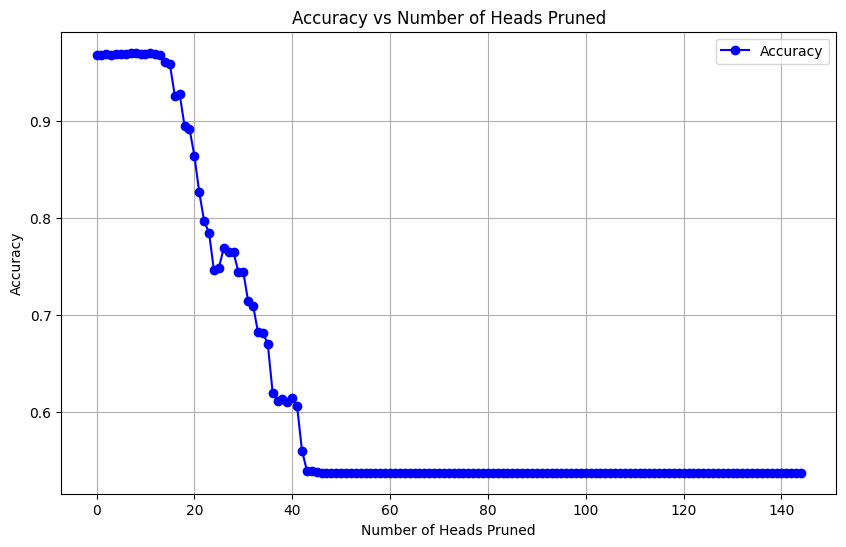

In [4]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(BERT_accs)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, BERT_accs, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [5]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(BERT_accs))),  # 剪掉头的数量
    'Accuracy': BERT_accs
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(BERT)basedonInverseGreedyGnorm.csv', index=False)


# ALBERT的Gnorm倒序裁剪

In [1]:
from datasets import load_dataset
import torch
from tqdm import tqdm
from textpruner import TransformerPruner
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Alireza1044/albert-base-v2-mnli")
model = AutoModelForSequenceClassification.from_pretrained("Alireza1044/albert-base-v2-mnli")
ds = load_dataset("nyu-mll/glue", "mnli")

d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")


In [2]:
def expand_weights_to_768x768(tensor, pruned_heads):
    # 初始化列表，存储拼接的张量
    tensors_to_concat = []
    start = 0
    # 按照 pruned_heads 进行插入
    for head_idx, keep in enumerate(pruned_heads):
        if keep == 1:
            # 如果该头保留，保留原来的 64x768
            tensors_to_concat.append(tensor[start:start+64, :])
            start += 64  # 每次移动 64 行
        else:
            # 如果该头被剪掉，插入 64x768 的零矩阵
            tensors_to_concat.append(torch.zeros(64, tensor.size(1)).to(tensor.device)) 
    # 将所有部分拼接起来，得到最终的 768x768 张量
    expanded_tensor = torch.cat(tensors_to_concat, dim=0)
    return expanded_tensor
def get_QKV_norm(ds, model, tokenizer, pruned_heads, batch_size=32, device='cuda'):
    model.to(device)
    norms_Q = torch.zeros(1, 12).to(device)
    norms_K = torch.zeros(1, 12).to(device)
    norms_V = torch.zeros(1, 12).to(device)
    all_premises = ds['validation_matched']['premise']
    all_hypothesises = ds['validation_matched']['hypothesis']
    for layer in range(1):
        attention_layer = model.albert.encoder.albert_layer_groups[layer].albert_layers[layer].attention
        heads_Q_weight = attention_layer.query.weight
        heads_K_weight = attention_layer.key.weight
        heads_V_weight = attention_layer.value.weight
        
        heads_Q_weight = heads_Q_weight.to(device)
        heads_K_weight = heads_K_weight.to(device)
        heads_V_weight = heads_V_weight.to(device)
        for i in range(0, len(all_premises), batch_size):
            batch_premises = all_premises[i:i+batch_size]
            batch_hypothesises = all_hypothesises[i:i+batch_size]
            inputs = tokenizer(batch_premises,batch_hypothesises, return_tensors='pt', padding=True, truncation=True)
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            sequence_output = outputs.logits
            loss = torch.norm(sequence_output)
            model.zero_grad()
            loss.backward()
            # 处理剪枝后的权重，扩展到 768x768
            GQ  = expand_weights_to_768x768(heads_Q_weight.grad, pruned_heads[layer])
            GK  = expand_weights_to_768x768(heads_K_weight.grad, pruned_heads[layer])
            GV  = expand_weights_to_768x768(heads_V_weight.grad, pruned_heads[layer])
            tensor_Q_reshaped = GQ.view(12, 64, 768)
            tensor_K_reshaped = GK.view(12, 64, 768)
            tensor_V_reshaped = GV.view(12, 64, 768)
            l2_Q_norms = torch.norm(tensor_Q_reshaped, p=2, dim=(1, 2))
            l2_K_norms = torch.norm(tensor_K_reshaped, p=2, dim=(1, 2))
            l2_V_norms = torch.norm(tensor_V_reshaped, p=2, dim=(1, 2))
            norms_Q[layer] += l2_Q_norms
            norms_K[layer] += l2_K_norms
            norms_V[layer] += l2_V_norms
        model.zero_grad()
    norms_Q = norms_Q.cpu() / len(all_premises)
    norms_K = norms_K.cpu() / len(all_premises)
    norms_V = norms_V.cpu() / len(all_premises)
    norms = norms_Q * norms_K * norms_V
    mean_norms = norms.mean()
    std_norms = norms.std()
    normalized = (norms - mean_norms) / std_norms
    return normalized
def get_new_head_mask_basedonG(head_mask_previous,Gnorm):
    selected_matrix = head_mask_previous * (Gnorm)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    print('layer:',layer,'\nhead:',head)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,size=len(ds['validation_matched']),device='cuda'):
    count = 0
    cursor = 0
    model.to(device)
    for data in tqdm(ds['validation_matched']):
        cursor += 1
        inputs = tokenizer(data['premise'],data['hypothesis'],return_tensors='pt').to(device) # 这里会自动在两个输入的语句中插入分隔符
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        if predicted_class_id == data['label']:
            count += 1
        if cursor > size:
            break
    return count / size
def prune_based_on_G(ds,model,tokenizer):
    head_mask = torch.tensor([[1]*12]*1)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(12)):
        Gnorm = get_QKV_norm(ds,model,tokenizer,pruned_heads=head_mask)
        head_mask = get_new_head_mask_basedonG(head_mask,Gnorm)
        print('head_mask',head_mask)
        model.to('cuda')
        pruner.prune(head_mask=head_mask,save_model=False)
        acc_score = get_acc(ds,model,tokenizer)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [3]:
accs_albert = prune_based_on_G(ds, model, tokenizer)

100%|██████████| 9815/9815 [00:59<00:00, 164.76it/s]


pruned heads: 0 acc: 0.8448293428425879


  0%|          | 0/12 [00:00<?, ?it/s]

layer: tensor(0) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]])


  8%|▊         | 1/12 [01:51<20:31, 111.95s/it]

pruned heads: 1 acc: 0.31451859398879267
layer: tensor(0) 
head: tensor(0)
head_mask tensor([[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]])


 17%|█▋        | 2/12 [03:44<18:40, 112.06s/it]

pruned heads: 2 acc: 0.47356087620988285
layer: tensor(0) 
head: tensor(8)
head_mask tensor([[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]])


 25%|██▌       | 3/12 [05:30<16:25, 109.47s/it]

pruned heads: 3 acc: 0.3273560876209883
layer: tensor(0) 
head: tensor(1)
head_mask tensor([[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]])


 33%|███▎      | 4/12 [07:41<15:43, 117.96s/it]

pruned heads: 4 acc: 0.34926133469179826
layer: tensor(0) 
head: tensor(11)
head_mask tensor([[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]])


 42%|████▏     | 5/12 [09:26<13:14, 113.48s/it]

pruned heads: 5 acc: 0.3272542027508915
layer: tensor(0) 
head: tensor(9)
head_mask tensor([[0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]])


 50%|█████     | 6/12 [11:14<11:09, 111.54s/it]

pruned heads: 6 acc: 0.3777890983188996
layer: tensor(0) 
head: tensor(7)
head_mask tensor([[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]])


 58%|█████▊    | 7/12 [12:59<09:07, 109.42s/it]

pruned heads: 7 acc: 0.3183902190524707
layer: tensor(0) 
head: tensor(4)
head_mask tensor([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]])


 67%|██████▋   | 8/12 [14:42<07:08, 107.21s/it]

pruned heads: 8 acc: 0.3169638308711156
layer: tensor(0) 
head: tensor(3)
head_mask tensor([[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]])


 75%|███████▌  | 9/12 [16:21<05:13, 104.58s/it]

pruned heads: 9 acc: 0.32103922567498727
layer: tensor(0) 
head: tensor(10)
head_mask tensor([[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


 83%|████████▎ | 10/12 [17:57<03:24, 102.01s/it]

pruned heads: 10 acc: 0.31818644931227713
layer: tensor(0) 
head: tensor(2)
head_mask tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


 92%|█████████▏| 11/12 [19:31<01:39, 99.60s/it] 

pruned heads: 11 acc: 0.31818644931227713


d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


layer: tensor(0) 
head: tensor(6)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


100%|██████████| 12/12 [20:54<00:00, 104.54s/it]

pruned heads: 12 acc: 0.31818644931227713


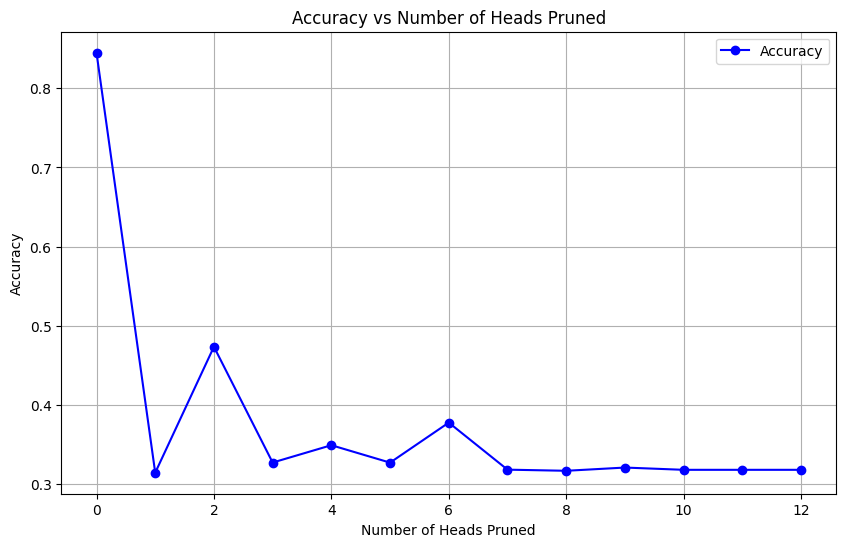

In [4]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(accs_albert)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, accs_albert, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [5]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(accs_albert))),  # 剪掉头的数量
    'Accuracy': accs_albert
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(ALBERT)basedonInverseGreedyGnorm.csv', index=False)


# ROBERTA裁剪

In [1]:
# Load model directly
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")
ds = load_dataset("rahmaabusalma/tweets_sentiment_analysis")

d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")


In [2]:
import torch
from tqdm import tqdm
def expand_weights_to_1024x1024(tensor, pruned_heads):
    # 初始化列表，存储拼接的张量
    tensors_to_concat = []
    start = 0
    # 按照 pruned_heads 进行插入
    for head_idx, keep in enumerate(pruned_heads):
        if keep == 1:
            tensors_to_concat.append(tensor[start:start+64, :])
            start += 64  # 每次移动 64 行
        else:
            tensors_to_concat.append(torch.zeros(64, tensor.size(1)).to(tensor.device)) 
    expanded_tensor = torch.cat(tensors_to_concat, dim=0)
    return expanded_tensor
def get_QKV_norm(ds, model, tokenizer, pruned_heads, batch_size=32, device='cuda'):
    model.to(device)
    norms_Q = torch.zeros(24, 16).to(device)
    norms_K = torch.zeros(24, 16).to(device)
    norms_V = torch.zeros(24, 16).to(device)
    all_titles = ds['validation']['text']
    for layer in range(24):
        attention_layer = model.roberta.encoder.layer[layer].attention.self
        heads_Q_weight = attention_layer.query.weight
        heads_K_weight = attention_layer.key.weight
        heads_V_weight = attention_layer.value.weight
        heads_Q_weight = heads_Q_weight.to(device)
        heads_K_weight = heads_K_weight.to(device)
        heads_V_weight = heads_V_weight.to(device)
        for i in range(0, 250, batch_size):
            batch_titles = all_titles[i:i+batch_size]
            inputs = tokenizer(batch_titles, return_tensors='pt', padding=True, truncation=True)
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            sequence_output = outputs.logits
            loss = torch.norm(sequence_output)
            model.zero_grad()
            loss.backward()
            GQ  = expand_weights_to_1024x1024(heads_Q_weight.grad, pruned_heads[layer])
            GK  = expand_weights_to_1024x1024(heads_K_weight.grad, pruned_heads[layer])
            GV  = expand_weights_to_1024x1024(heads_V_weight.grad, pruned_heads[layer])
            tensor_Q_reshaped = GQ.view(16, 64, 1024)
            tensor_K_reshaped = GK.view(16, 64, 1024)
            tensor_V_reshaped = GV.view(16, 64, 1024)
            l2_Q_norms = torch.norm(tensor_Q_reshaped, p=2, dim=(1, 2))
            l2_K_norms = torch.norm(tensor_K_reshaped, p=2, dim=(1, 2))
            l2_V_norms = torch.norm(tensor_V_reshaped, p=2, dim=(1, 2))
            norms_Q[layer] += l2_Q_norms
            norms_K[layer] += l2_K_norms
            norms_V[layer] += l2_V_norms
        model.zero_grad()
    norms_Q = norms_Q.cpu() / len(all_titles)
    norms_K = norms_K.cpu() / len(all_titles)
    norms_V = norms_V.cpu() / len(all_titles)
    norms = norms_Q * norms_K * norms_V
    mean_norms = norms.mean()
    std_norms = norms.std()
    normalized = (norms - mean_norms) / std_norms
    return normalized
def get_new_head_mask_basedonG(head_mask_previous,Gnorm):
    selected_matrix = head_mask_previous * (Gnorm)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    print('layer:',layer,'\nhead:',head)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,size=len(ds['validation']),device='cuda'):
    count = 0
    cursor = 0
    model.to(device)
    for data in tqdm(ds['validation']):
        if data['label']==1:
            continue
        cursor += 1
        inputs = tokenizer(data['text'],return_tensors='pt').to(device) # 这里会自动在两个输入的语句中插入分隔符
        with torch.no_grad():
            predicted_class_id = model(**inputs)
        if torch.max(predicted_class_id[0],dim=1).indices[0] == (1 if data['label']==2 else 0):
            count += 1
        if cursor > size:
            break
    return count / size
def prune_based_on_G(ds,model,tokenizer):
    head_mask = torch.tensor([[1]*16]*24)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer,1000))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(384)):
        Gnorm = get_QKV_norm(ds,model,tokenizer,pruned_heads=head_mask,batch_size=4)
        head_mask = get_new_head_mask_basedonG(head_mask,Gnorm)
        model.to('cuda')
        print('head_mask',head_mask)
        pruner.prune(head_mask=head_mask,save_model=False)
        acc_score = get_acc(ds,model,tokenizer,1000)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [3]:
from datasets import load_dataset
import torch
from tqdm import tqdm
from textpruner import TransformerPruner
from transformers import AutoTokenizer, AutoModelForSequenceClassification

accs_roberta = prune_based_on_G(ds,model,tokenizer)

 30%|███       | 1583/5205 [00:10<00:23, 151.00it/s]


pruned heads: 0 acc: 0.878


  0%|          | 0/384 [00:00<?, ?it/s]

layer: tensor(10) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 

  0%|          | 1/384 [01:07<7:12:18, 67.72s/it]

pruned heads: 1 acc: 0.881
layer: tensor(12) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  1%|          | 2/384 [02:18<7:24:06, 69.75s/it]

pruned heads: 2 acc: 0.886
layer: tensor(13) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  1%|          | 3/384 [03:31<7:32:14, 71.22s/it]

pruned heads: 3 acc: 0.89
layer: tensor(13) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  1%|          | 4/384 [04:46<7:38:24, 72.38s/it]

pruned heads: 4 acc: 0.888
layer: tensor(12) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  1%|▏         | 5/384 [05:59<7:40:45, 72.94s/it]

pruned heads: 5 acc: 0.886
layer: tensor(13) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  2%|▏         | 6/384 [07:12<7:39:39, 72.96s/it]

pruned heads: 6 acc: 0.881
layer: tensor(10) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  2%|▏         | 7/384 [08:26<7:40:15, 73.25s/it]

pruned heads: 7 acc: 0.885
layer: tensor(12) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  2%|▏         | 8/384 [09:41<7:41:09, 73.59s/it]

pruned heads: 8 acc: 0.881
layer: tensor(14) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  2%|▏         | 9/384 [10:55<7:41:06, 73.78s/it]

pruned heads: 9 acc: 0.883
layer: tensor(14) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  3%|▎         | 10/384 [12:09<7:40:31, 73.88s/it]

pruned heads: 10 acc: 0.887
layer: tensor(16) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  3%|▎         | 11/384 [13:22<7:37:39, 73.62s/it]

pruned heads: 11 acc: 0.889
layer: tensor(13) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  3%|▎         | 12/384 [14:35<7:36:09, 73.58s/it]

pruned heads: 12 acc: 0.885
layer: tensor(11) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  3%|▎         | 13/384 [15:50<7:36:47, 73.87s/it]

pruned heads: 13 acc: 0.889
layer: tensor(12) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  4%|▎         | 14/384 [17:04<7:36:00, 73.95s/it]

pruned heads: 14 acc: 0.888
layer: tensor(14) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  4%|▍         | 15/384 [18:18<7:34:24, 73.89s/it]

pruned heads: 15 acc: 0.89
layer: tensor(15) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  4%|▍         | 16/384 [19:32<7:34:22, 74.08s/it]

pruned heads: 16 acc: 0.891
layer: tensor(15) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  4%|▍         | 17/384 [20:46<7:32:28, 73.97s/it]

pruned heads: 17 acc: 0.895
layer: tensor(12) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  5%|▍         | 18/384 [22:01<7:32:15, 74.14s/it]

pruned heads: 18 acc: 0.891
layer: tensor(12) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  5%|▍         | 19/384 [23:15<7:30:32, 74.06s/it]

pruned heads: 19 acc: 0.89
layer: tensor(11) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  5%|▌         | 20/384 [24:28<7:29:01, 74.02s/it]

pruned heads: 20 acc: 0.893
layer: tensor(9) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


  5%|▌         | 21/384 [25:42<7:26:12, 73.75s/it]

pruned heads: 21 acc: 0.894
layer: tensor(10) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  6%|▌         | 22/384 [26:55<7:25:11, 73.79s/it]

pruned heads: 22 acc: 0.889
layer: tensor(16) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  6%|▌         | 23/384 [28:09<7:24:25, 73.87s/it]

pruned heads: 23 acc: 0.888
layer: tensor(9) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  6%|▋         | 24/384 [29:24<7:24:00, 74.00s/it]

pruned heads: 24 acc: 0.882
layer: tensor(10) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  7%|▋         | 25/384 [30:37<7:22:02, 73.88s/it]

pruned heads: 25 acc: 0.882
layer: tensor(13) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  7%|▋         | 26/384 [31:51<7:20:27, 73.82s/it]

pruned heads: 26 acc: 0.881
layer: tensor(12) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  7%|▋         | 27/384 [33:05<7:18:51, 73.76s/it]

pruned heads: 27 acc: 0.88
layer: tensor(13) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  7%|▋         | 28/384 [34:18<7:17:22, 73.71s/it]

pruned heads: 28 acc: 0.876
layer: tensor(13) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  8%|▊         | 29/384 [35:32<7:16:22, 73.75s/it]

pruned heads: 29 acc: 0.886
layer: tensor(16) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  8%|▊         | 30/384 [36:45<7:14:14, 73.60s/it]

pruned heads: 30 acc: 0.882
layer: tensor(13) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  8%|▊         | 31/384 [37:59<7:13:13, 73.64s/it]

pruned heads: 31 acc: 0.882
layer: tensor(15) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  8%|▊         | 32/384 [39:12<7:11:21, 73.53s/it]

pruned heads: 32 acc: 0.891
layer: tensor(16) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

  9%|▊         | 33/384 [40:26<7:09:49, 73.47s/it]

pruned heads: 33 acc: 0.891
layer: tensor(13) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  9%|▉         | 34/384 [41:40<7:10:03, 73.72s/it]

pruned heads: 34 acc: 0.889
layer: tensor(14) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  9%|▉         | 35/384 [42:53<7:07:03, 73.42s/it]

pruned heads: 35 acc: 0.891
layer: tensor(17) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

  9%|▉         | 36/384 [44:06<7:05:53, 73.43s/it]

pruned heads: 36 acc: 0.891
layer: tensor(17) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 10%|▉         | 37/384 [45:20<7:04:33, 73.41s/it]

pruned heads: 37 acc: 0.883
layer: tensor(15) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

 10%|▉         | 38/384 [46:33<7:03:00, 73.35s/it]

pruned heads: 38 acc: 0.885
layer: tensor(15) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

 10%|█         | 39/384 [47:47<7:02:35, 73.49s/it]

pruned heads: 39 acc: 0.885
layer: tensor(17) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

 10%|█         | 40/384 [48:59<6:59:57, 73.25s/it]

pruned heads: 40 acc: 0.877
layer: tensor(17) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],

 11%|█         | 41/384 [50:13<6:58:48, 73.26s/it]

pruned heads: 41 acc: 0.863
layer: tensor(16) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],

 11%|█         | 42/384 [51:26<6:58:00, 73.34s/it]

pruned heads: 42 acc: 0.873
layer: tensor(16) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

 11%|█         | 43/384 [52:40<6:57:25, 73.45s/it]

pruned heads: 43 acc: 0.872
layer: tensor(16) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

 11%|█▏        | 44/384 [53:53<6:56:14, 73.45s/it]

pruned heads: 44 acc: 0.877
layer: tensor(16) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],

 12%|█▏        | 45/384 [55:06<6:53:37, 73.21s/it]

pruned heads: 45 acc: 0.876
layer: tensor(16) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],

 12%|█▏        | 46/384 [56:18<6:50:51, 72.93s/it]

pruned heads: 46 acc: 0.879
layer: tensor(14) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],

 12%|█▏        | 47/384 [57:31<6:48:47, 72.78s/it]

pruned heads: 47 acc: 0.879
layer: tensor(15) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 12%|█▎        | 48/384 [58:44<6:48:11, 72.89s/it]

pruned heads: 48 acc: 0.875
layer: tensor(16) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 13%|█▎        | 49/384 [59:57<6:48:01, 73.08s/it]

pruned heads: 49 acc: 0.872
layer: tensor(16) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 13%|█▎        | 50/384 [1:01:10<6:45:34, 72.86s/it]

pruned heads: 50 acc: 0.874
layer: tensor(17) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],

 13%|█▎        | 51/384 [1:02:22<6:43:22, 72.68s/it]

pruned heads: 51 acc: 0.874
layer: tensor(18) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 14%|█▎        | 52/384 [1:03:34<6:41:43, 72.60s/it]

pruned heads: 52 acc: 0.868
layer: tensor(18) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 14%|█▍        | 53/384 [1:04:48<6:42:16, 72.92s/it]

pruned heads: 53 acc: 0.867
layer: tensor(18) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],

 14%|█▍        | 54/384 [1:06:01<6:41:55, 73.08s/it]

pruned heads: 54 acc: 0.85
layer: tensor(17) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],

 14%|█▍        | 55/384 [1:07:14<6:39:57, 72.94s/it]

pruned heads: 55 acc: 0.831
layer: tensor(17) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 15%|█▍        | 56/384 [1:08:26<6:37:56, 72.79s/it]

pruned heads: 56 acc: 0.836
layer: tensor(18) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],

 15%|█▍        | 57/384 [1:09:40<6:38:17, 73.08s/it]

pruned heads: 57 acc: 0.843
layer: tensor(17) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],

 15%|█▌        | 58/384 [1:10:53<6:36:25, 72.96s/it]

pruned heads: 58 acc: 0.813
layer: tensor(17) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]

 15%|█▌        | 59/384 [1:12:06<6:35:57, 73.10s/it]

pruned heads: 59 acc: 0.801
layer: tensor(15) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1],

 16%|█▌        | 60/384 [1:13:18<6:33:05, 72.80s/it]

pruned heads: 60 acc: 0.796
layer: tensor(15) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

 16%|█▌        | 61/384 [1:14:31<6:30:56, 72.62s/it]

pruned heads: 61 acc: 0.794
layer: tensor(18) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 16%|█▌        | 62/384 [1:15:43<6:29:09, 72.51s/it]

pruned heads: 62 acc: 0.788
layer: tensor(18) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 16%|█▋        | 63/384 [1:16:56<6:28:20, 72.59s/it]

pruned heads: 63 acc: 0.804
layer: tensor(17) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 17%|█▋        | 64/384 [1:18:09<6:29:01, 72.94s/it]

pruned heads: 64 acc: 0.787
layer: tensor(17) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

 17%|█▋        | 65/384 [1:19:22<6:26:41, 72.73s/it]

pruned heads: 65 acc: 0.785
layer: tensor(17) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 17%|█▋        | 66/384 [1:20:34<6:24:53, 72.62s/it]

pruned heads: 66 acc: 0.797
layer: tensor(19) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 17%|█▋        | 67/384 [1:21:47<6:24:55, 72.86s/it]

pruned heads: 67 acc: 0.797
layer: tensor(19) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 18%|█▊        | 68/384 [1:23:01<6:24:28, 73.00s/it]

pruned heads: 68 acc: 0.809
layer: tensor(17) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 18%|█▊        | 69/384 [1:24:14<6:23:48, 73.11s/it]

pruned heads: 69 acc: 0.798
layer: tensor(14) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 18%|█▊        | 70/384 [1:25:27<6:21:56, 72.98s/it]

pruned heads: 70 acc: 0.793
layer: tensor(18) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],

 18%|█▊        | 71/384 [1:26:39<6:19:51, 72.82s/it]

pruned heads: 71 acc: 0.785
layer: tensor(15) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 19%|█▉        | 72/384 [1:27:53<6:20:39, 73.20s/it]

pruned heads: 72 acc: 0.785
layer: tensor(18) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 19%|█▉        | 73/384 [1:29:06<6:18:18, 72.99s/it]

pruned heads: 73 acc: 0.785
layer: tensor(17) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 19%|█▉        | 74/384 [1:30:18<6:15:32, 72.68s/it]

pruned heads: 74 acc: 0.792
layer: tensor(18) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 20%|█▉        | 75/384 [1:31:31<6:14:42, 72.76s/it]

pruned heads: 75 acc: 0.797
layer: tensor(18) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 20%|█▉        | 76/384 [1:32:42<6:11:44, 72.42s/it]

pruned heads: 76 acc: 0.808
layer: tensor(18) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 20%|██        | 77/384 [1:33:55<6:10:14, 72.36s/it]

pruned heads: 77 acc: 0.799
layer: tensor(19) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 20%|██        | 78/384 [1:35:07<6:09:22, 72.43s/it]

pruned heads: 78 acc: 0.786
layer: tensor(18) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 21%|██        | 79/384 [1:36:20<6:08:21, 72.46s/it]

pruned heads: 79 acc: 0.766
layer: tensor(18) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 21%|██        | 80/384 [1:37:32<6:07:09, 72.46s/it]

pruned heads: 80 acc: 0.767
layer: tensor(18) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 21%|██        | 81/384 [1:38:44<6:05:10, 72.31s/it]

pruned heads: 81 acc: 0.765
layer: tensor(18) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 21%|██▏       | 82/384 [1:39:57<6:05:26, 72.61s/it]

pruned heads: 82 acc: 0.769
layer: tensor(19) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 22%|██▏       | 83/384 [1:41:11<6:04:54, 72.74s/it]

pruned heads: 83 acc: 0.769
layer: tensor(19) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 22%|██▏       | 84/384 [1:42:23<6:02:43, 72.54s/it]

pruned heads: 84 acc: 0.751
layer: tensor(19) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 22%|██▏       | 85/384 [1:43:35<6:01:31, 72.55s/it]

pruned heads: 85 acc: 0.716
layer: tensor(16) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 22%|██▏       | 86/384 [1:44:47<5:59:20, 72.35s/it]

pruned heads: 86 acc: 0.713
layer: tensor(14) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 23%|██▎       | 87/384 [1:46:00<5:59:19, 72.59s/it]

pruned heads: 87 acc: 0.733
layer: tensor(19) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 23%|██▎       | 88/384 [1:47:13<5:58:02, 72.58s/it]

pruned heads: 88 acc: 0.719
layer: tensor(20) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 23%|██▎       | 89/384 [1:48:25<5:55:53, 72.38s/it]

pruned heads: 89 acc: 0.715
layer: tensor(20) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 23%|██▎       | 90/384 [1:49:36<5:53:49, 72.21s/it]

pruned heads: 90 acc: 0.678
layer: tensor(19) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 24%|██▎       | 91/384 [1:50:48<5:51:13, 71.92s/it]

pruned heads: 91 acc: 0.696
layer: tensor(20) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 24%|██▍       | 92/384 [1:52:00<5:51:04, 72.14s/it]

pruned heads: 92 acc: 0.718
layer: tensor(19) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 24%|██▍       | 93/384 [1:53:13<5:50:46, 72.32s/it]

pruned heads: 93 acc: 0.727
layer: tensor(19) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 24%|██▍       | 94/384 [1:54:25<5:48:58, 72.20s/it]

pruned heads: 94 acc: 0.691
layer: tensor(19) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 25%|██▍       | 95/384 [1:55:36<5:46:31, 71.94s/it]

pruned heads: 95 acc: 0.642
layer: tensor(20) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 25%|██▌       | 96/384 [1:56:49<5:45:36, 72.00s/it]

pruned heads: 96 acc: 0.658
layer: tensor(19) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 25%|██▌       | 97/384 [1:58:01<5:45:40, 72.27s/it]

pruned heads: 97 acc: 0.639
layer: tensor(20) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 26%|██▌       | 98/384 [1:59:13<5:43:29, 72.06s/it]

pruned heads: 98 acc: 0.653
layer: tensor(20) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 26%|██▌       | 99/384 [2:00:25<5:41:58, 72.00s/it]

pruned heads: 99 acc: 0.633
layer: tensor(20) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 26%|██▌       | 100/384 [2:01:36<5:39:52, 71.81s/it]

pruned heads: 100 acc: 0.651
layer: tensor(21) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 26%|██▋       | 101/384 [2:02:47<5:37:26, 71.54s/it]

pruned heads: 101 acc: 0.668
layer: tensor(19) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 27%|██▋       | 102/384 [2:03:59<5:36:56, 71.69s/it]

pruned heads: 102 acc: 0.657
layer: tensor(19) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 27%|██▋       | 103/384 [2:05:11<5:36:23, 71.83s/it]

pruned heads: 103 acc: 0.673
layer: tensor(21) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 27%|██▋       | 104/384 [2:06:23<5:34:51, 71.75s/it]

pruned heads: 104 acc: 0.662
layer: tensor(20) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 27%|██▋       | 105/384 [2:07:34<5:33:17, 71.67s/it]

pruned heads: 105 acc: 0.67
layer: tensor(21) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 28%|██▊       | 106/384 [2:08:46<5:31:48, 71.61s/it]

pruned heads: 106 acc: 0.703
layer: tensor(21) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 28%|██▊       | 107/384 [2:09:59<5:32:09, 71.95s/it]

pruned heads: 107 acc: 0.698
layer: tensor(21) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 28%|██▊       | 108/384 [2:11:10<5:30:35, 71.87s/it]

pruned heads: 108 acc: 0.684
layer: tensor(20) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 28%|██▊       | 109/384 [2:12:22<5:28:34, 71.69s/it]

pruned heads: 109 acc: 0.686
layer: tensor(21) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 29%|██▊       | 110/384 [2:13:33<5:27:08, 71.64s/it]

pruned heads: 110 acc: 0.686
layer: tensor(20) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 29%|██▉       | 111/384 [2:14:44<5:25:06, 71.45s/it]

pruned heads: 111 acc: 0.68
layer: tensor(20) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 29%|██▉       | 112/384 [2:15:56<5:25:13, 71.74s/it]

pruned heads: 112 acc: 0.642
layer: tensor(21) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 29%|██▉       | 113/384 [2:17:09<5:24:30, 71.85s/it]

pruned heads: 113 acc: 0.644
layer: tensor(21) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 30%|██▉       | 114/384 [2:18:20<5:23:25, 71.87s/it]

pruned heads: 114 acc: 0.642
layer: tensor(21) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 30%|██▉       | 115/384 [2:19:32<5:21:59, 71.82s/it]

pruned heads: 115 acc: 0.642


d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


layer: tensor(18) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1,

 30%|███       | 116/384 [2:20:43<5:19:17, 71.48s/it]

pruned heads: 116 acc: 0.659
layer: tensor(21) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 30%|███       | 117/384 [2:21:54<5:17:40, 71.39s/it]

pruned heads: 117 acc: 0.66
layer: tensor(22) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 31%|███       | 118/384 [2:23:06<5:16:48, 71.46s/it]

pruned heads: 118 acc: 0.639
layer: tensor(22) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 31%|███       | 119/384 [2:24:16<5:14:38, 71.24s/it]

pruned heads: 119 acc: 0.65
layer: tensor(20) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 31%|███▏      | 120/384 [2:25:27<5:12:53, 71.11s/it]

pruned heads: 120 acc: 0.654
layer: tensor(22) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 32%|███▏      | 121/384 [2:26:37<5:10:27, 70.83s/it]

pruned heads: 121 acc: 0.651
layer: tensor(22) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 32%|███▏      | 122/384 [2:27:48<5:08:22, 70.62s/it]

pruned heads: 122 acc: 0.649
layer: tensor(19) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 32%|███▏      | 123/384 [2:28:59<5:07:54, 70.78s/it]

pruned heads: 123 acc: 0.629
layer: tensor(20) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 32%|███▏      | 124/384 [2:30:10<5:07:01, 70.85s/it]

pruned heads: 124 acc: 0.648
layer: tensor(17) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 33%|███▎      | 125/384 [2:31:21<5:06:10, 70.93s/it]

pruned heads: 125 acc: 0.65
layer: tensor(20) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 33%|███▎      | 126/384 [2:32:31<5:04:34, 70.83s/it]

pruned heads: 126 acc: 0.646
layer: tensor(21) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 33%|███▎      | 127/384 [2:33:42<5:02:27, 70.61s/it]

pruned heads: 127 acc: 0.635
layer: tensor(21) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 33%|███▎      | 128/384 [2:34:53<5:02:34, 70.91s/it]

pruned heads: 128 acc: 0.641
layer: tensor(22) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 34%|███▎      | 129/384 [2:36:04<5:01:28, 70.94s/it]

pruned heads: 129 acc: 0.63
layer: tensor(21) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 34%|███▍      | 130/384 [2:37:14<4:58:42, 70.56s/it]

pruned heads: 130 acc: 0.638
layer: tensor(22) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 34%|███▍      | 131/384 [2:38:24<4:56:55, 70.42s/it]

pruned heads: 131 acc: 0.658
layer: tensor(22) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 34%|███▍      | 132/384 [2:39:35<4:57:08, 70.75s/it]

pruned heads: 132 acc: 0.634
layer: tensor(22) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 35%|███▍      | 133/384 [2:40:46<4:55:51, 70.72s/it]

pruned heads: 133 acc: 0.627
layer: tensor(22) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 35%|███▍      | 134/384 [2:41:57<4:54:54, 70.78s/it]

pruned heads: 134 acc: 0.609
layer: tensor(22) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 35%|███▌      | 135/384 [2:43:07<4:52:54, 70.58s/it]

pruned heads: 135 acc: 0.608
layer: tensor(22) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 35%|███▌      | 136/384 [2:44:17<4:50:56, 70.39s/it]

pruned heads: 136 acc: 0.607
layer: tensor(22) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 36%|███▌      | 137/384 [2:45:27<4:49:07, 70.23s/it]

pruned heads: 137 acc: 0.608
layer: tensor(23) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 36%|███▌      | 138/384 [2:46:37<4:48:10, 70.29s/it]

pruned heads: 138 acc: 0.604
layer: tensor(22) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 36%|███▌      | 139/384 [2:47:48<4:47:29, 70.40s/it]

pruned heads: 139 acc: 0.638
layer: tensor(22) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 36%|███▋      | 140/384 [2:48:58<4:45:30, 70.21s/it]

pruned heads: 140 acc: 0.627
layer: tensor(23) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 37%|███▋      | 141/384 [2:50:09<4:45:24, 70.47s/it]

pruned heads: 141 acc: 0.637
layer: tensor(23) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0

 37%|███▋      | 142/384 [2:51:19<4:43:45, 70.35s/it]

pruned heads: 142 acc: 0.63
layer: tensor(23) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 37%|███▋      | 143/384 [2:52:29<4:42:50, 70.42s/it]

pruned heads: 143 acc: 0.618
layer: tensor(23) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 38%|███▊      | 144/384 [2:53:41<4:42:38, 70.66s/it]

pruned heads: 144 acc: 0.599
layer: tensor(21) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 38%|███▊      | 145/384 [2:54:50<4:40:21, 70.38s/it]

pruned heads: 145 acc: 0.585
layer: tensor(23) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 38%|███▊      | 146/384 [2:56:01<4:39:18, 70.41s/it]

pruned heads: 146 acc: 0.55
layer: tensor(23) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 38%|███▊      | 147/384 [2:57:11<4:37:08, 70.16s/it]

pruned heads: 147 acc: 0.55
layer: tensor(20) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 39%|███▊      | 148/384 [2:58:20<4:35:24, 70.02s/it]

pruned heads: 148 acc: 0.55
layer: tensor(23) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 39%|███▉      | 149/384 [2:59:30<4:34:14, 70.02s/it]

pruned heads: 149 acc: 0.55
layer: tensor(23) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 39%|███▉      | 150/384 [3:00:40<4:32:57, 69.99s/it]

pruned heads: 150 acc: 0.552
layer: tensor(23) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 39%|███▉      | 151/384 [3:01:50<4:31:52, 70.01s/it]

pruned heads: 151 acc: 0.55
layer: tensor(23) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 40%|███▉      | 152/384 [3:03:00<4:30:21, 69.92s/it]

pruned heads: 152 acc: 0.55
layer: tensor(23) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 40%|███▉      | 153/384 [3:04:10<4:29:31, 70.01s/it]

pruned heads: 153 acc: 0.55
layer: tensor(23) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 40%|████      | 154/384 [3:05:20<4:28:08, 69.95s/it]

pruned heads: 154 acc: 0.55
layer: tensor(23) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]

 40%|████      | 155/384 [3:06:30<4:27:15, 70.03s/it]

pruned heads: 155 acc: 0.55
layer: tensor(23) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 41%|████      | 156/384 [3:07:40<4:25:42, 69.92s/it]

pruned heads: 156 acc: 0.55
layer: tensor(23) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0],

 41%|████      | 157/384 [3:08:49<4:23:30, 69.65s/it]

pruned heads: 157 acc: 0.55
layer: tensor(15) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0],

 41%|████      | 158/384 [3:09:59<4:22:41, 69.74s/it]

pruned heads: 158 acc: 0.55
layer: tensor(14) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]

 41%|████▏     | 159/384 [3:11:09<4:21:54, 69.84s/it]

pruned heads: 159 acc: 0.55
layer: tensor(15) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]

 42%|████▏     | 160/384 [3:12:18<4:20:28, 69.77s/it]

pruned heads: 160 acc: 0.55
layer: tensor(16) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 42%|████▏     | 161/384 [3:13:28<4:18:56, 69.67s/it]

pruned heads: 161 acc: 0.55
layer: tensor(14) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 42%|████▏     | 162/384 [3:14:37<4:16:46, 69.40s/it]

pruned heads: 162 acc: 0.55
layer: tensor(17) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 42%|████▏     | 163/384 [3:15:46<4:15:02, 69.24s/it]

pruned heads: 163 acc: 0.55
layer: tensor(22) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 43%|████▎     | 164/384 [3:16:55<4:13:53, 69.24s/it]

pruned heads: 164 acc: 0.55
layer: tensor(22) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 43%|████▎     | 165/384 [3:18:04<4:12:20, 69.13s/it]

pruned heads: 165 acc: 0.55
layer: tensor(21) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 43%|████▎     | 166/384 [3:19:11<4:09:27, 68.66s/it]

pruned heads: 166 acc: 0.55
layer: tensor(11) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]

 43%|████▎     | 167/384 [3:20:18<4:06:32, 68.17s/it]

pruned heads: 167 acc: 0.55
layer: tensor(13) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 44%|████▍     | 168/384 [3:21:26<4:05:11, 68.11s/it]

pruned heads: 168 acc: 0.55
layer: tensor(16) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 44%|████▍     | 169/384 [3:22:35<4:04:38, 68.27s/it]

pruned heads: 169 acc: 0.55
layer: tensor(21) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]

 44%|████▍     | 170/384 [3:23:43<4:02:55, 68.11s/it]

pruned heads: 170 acc: 0.55
layer: tensor(14) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]

 45%|████▍     | 171/384 [3:24:50<4:00:40, 67.80s/it]

pruned heads: 171 acc: 0.55
layer: tensor(10) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],

 45%|████▍     | 172/384 [3:25:57<3:59:00, 67.65s/it]

pruned heads: 172 acc: 0.55
layer: tensor(15) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

 45%|████▌     | 173/384 [3:27:04<3:57:04, 67.42s/it]

pruned heads: 173 acc: 0.55
layer: tensor(14) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

 45%|████▌     | 174/384 [3:28:12<3:56:15, 67.50s/it]

pruned heads: 174 acc: 0.55
layer: tensor(12) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

 46%|████▌     | 175/384 [3:29:20<3:55:58, 67.75s/it]

pruned heads: 175 acc: 0.55
layer: tensor(15) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],

 46%|████▌     | 176/384 [3:30:28<3:54:49, 67.74s/it]

pruned heads: 176 acc: 0.55
layer: tensor(11) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

 46%|████▌     | 177/384 [3:31:35<3:53:00, 67.54s/it]

pruned heads: 177 acc: 0.55
layer: tensor(15) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],

 46%|████▋     | 178/384 [3:32:41<3:51:05, 67.31s/it]

pruned heads: 178 acc: 0.55
layer: tensor(19) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

 47%|████▋     | 179/384 [3:33:49<3:50:18, 67.41s/it]

pruned heads: 179 acc: 0.55
layer: tensor(15) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 47%|████▋     | 180/384 [3:34:56<3:48:49, 67.30s/it]

pruned heads: 180 acc: 0.55
layer: tensor(14) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

 47%|████▋     | 181/384 [3:36:03<3:47:08, 67.14s/it]

pruned heads: 181 acc: 0.55
layer: tensor(12) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 47%|████▋     | 182/384 [3:37:08<3:44:27, 66.67s/it]

pruned heads: 182 acc: 0.55
layer: tensor(13) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 48%|████▊     | 183/384 [3:38:15<3:43:03, 66.59s/it]

pruned heads: 183 acc: 0.55
layer: tensor(20) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 48%|████▊     | 184/384 [3:39:21<3:41:22, 66.41s/it]

pruned heads: 184 acc: 0.55
layer: tensor(8) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 48%|████▊     | 185/384 [3:40:27<3:39:43, 66.25s/it]

pruned heads: 185 acc: 0.55
layer: tensor(9) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 48%|████▊     | 186/384 [3:41:33<3:38:44, 66.28s/it]

pruned heads: 186 acc: 0.55
layer: tensor(9) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 49%|████▊     | 187/384 [3:42:39<3:37:17, 66.18s/it]

pruned heads: 187 acc: 0.55
layer: tensor(11) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 49%|████▉     | 188/384 [3:43:45<3:35:55, 66.10s/it]

pruned heads: 188 acc: 0.55
layer: tensor(16) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 49%|████▉     | 189/384 [3:44:51<3:34:23, 65.97s/it]

pruned heads: 189 acc: 0.55
layer: tensor(7) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 49%|████▉     | 190/384 [3:45:56<3:32:59, 65.88s/it]

pruned heads: 190 acc: 0.55
layer: tensor(13) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

 50%|████▉     | 191/384 [3:47:02<3:31:43, 65.82s/it]

pruned heads: 191 acc: 0.55
layer: tensor(14) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 50%|█████     | 192/384 [3:48:09<3:31:20, 66.05s/it]

pruned heads: 192 acc: 0.55
layer: tensor(14) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 50%|█████     | 193/384 [3:49:13<3:29:06, 65.69s/it]

pruned heads: 193 acc: 0.55
layer: tensor(9) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 51%|█████     | 194/384 [3:50:19<3:27:38, 65.57s/it]

pruned heads: 194 acc: 0.55
layer: tensor(8) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 51%|█████     | 195/384 [3:51:24<3:26:33, 65.57s/it]

pruned heads: 195 acc: 0.55
layer: tensor(9) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 51%|█████     | 196/384 [3:52:31<3:26:22, 65.86s/it]

pruned heads: 196 acc: 0.55
layer: tensor(14) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 51%|█████▏    | 197/384 [3:53:36<3:24:42, 65.68s/it]

pruned heads: 197 acc: 0.55
layer: tensor(14) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 52%|█████▏    | 198/384 [3:54:40<3:22:15, 65.25s/it]

pruned heads: 198 acc: 0.55
layer: tensor(10) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

 52%|█████▏    | 199/384 [3:56:30<4:02:26, 78.63s/it]

pruned heads: 199 acc: 0.55
layer: tensor(16) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 52%|█████▏    | 200/384 [3:58:39<4:47:23, 93.72s/it]

pruned heads: 200 acc: 0.55
layer: tensor(8) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 52%|█████▏    | 201/384 [4:00:14<4:46:57, 94.08s/it]

pruned heads: 201 acc: 0.55
layer: tensor(4) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 53%|█████▎    | 202/384 [4:01:20<4:19:26, 85.53s/it]

pruned heads: 202 acc: 0.55
layer: tensor(11) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 53%|█████▎    | 203/384 [4:02:24<3:59:12, 79.30s/it]

pruned heads: 203 acc: 0.55
layer: tensor(12) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 53%|█████▎    | 204/384 [4:03:29<3:44:28, 74.83s/it]

pruned heads: 204 acc: 0.55
layer: tensor(13) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 53%|█████▎    | 205/384 [4:04:34<3:34:58, 72.06s/it]

pruned heads: 205 acc: 0.55
layer: tensor(12) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

 54%|█████▎    | 206/384 [4:05:40<3:28:15, 70.20s/it]

pruned heads: 206 acc: 0.55
layer: tensor(7) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 54%|█████▍    | 207/384 [4:06:46<3:23:02, 68.83s/it]

pruned heads: 207 acc: 0.55
layer: tensor(12) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 54%|█████▍    | 208/384 [4:07:52<3:19:16, 67.94s/it]

pruned heads: 208 acc: 0.55
layer: tensor(10) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 54%|█████▍    | 209/384 [4:08:56<3:15:13, 66.94s/it]

pruned heads: 209 acc: 0.55
layer: tensor(8) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 55%|█████▍    | 210/384 [4:10:02<3:13:00, 66.55s/it]

pruned heads: 210 acc: 0.55
layer: tensor(10) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

 55%|█████▍    | 211/384 [4:11:09<3:11:56, 66.57s/it]

pruned heads: 211 acc: 0.55
layer: tensor(12) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 55%|█████▌    | 212/384 [4:12:14<3:09:51, 66.23s/it]

pruned heads: 212 acc: 0.55
layer: tensor(9) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 55%|█████▌    | 213/384 [4:13:20<3:08:14, 66.05s/it]

pruned heads: 213 acc: 0.55
layer: tensor(8) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],

 56%|█████▌    | 214/384 [4:14:25<3:06:19, 65.76s/it]

pruned heads: 214 acc: 0.55
layer: tensor(6) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],


 56%|█████▌    | 215/384 [4:15:31<3:05:56, 66.01s/it]

pruned heads: 215 acc: 0.55
layer: tensor(15) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 56%|█████▋    | 216/384 [4:16:37<3:04:31, 65.90s/it]

pruned heads: 216 acc: 0.55
layer: tensor(13) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 57%|█████▋    | 217/384 [4:17:42<3:02:31, 65.58s/it]

pruned heads: 217 acc: 0.55
layer: tensor(12) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 57%|█████▋    | 218/384 [4:18:47<3:00:46, 65.34s/it]

pruned heads: 218 acc: 0.55
layer: tensor(13) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 57%|█████▋    | 219/384 [4:19:52<2:59:26, 65.25s/it]

pruned heads: 219 acc: 0.55
layer: tensor(12) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 57%|█████▋    | 220/384 [4:20:57<2:58:12, 65.20s/it]

pruned heads: 220 acc: 0.55
layer: tensor(13) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 58%|█████▊    | 221/384 [4:22:02<2:56:53, 65.12s/it]

pruned heads: 221 acc: 0.55
layer: tensor(10) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 58%|█████▊    | 222/384 [4:23:07<2:55:41, 65.07s/it]

pruned heads: 222 acc: 0.55
layer: tensor(8) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 58%|█████▊    | 223/384 [4:24:11<2:54:17, 64.95s/it]

pruned heads: 223 acc: 0.55
layer: tensor(11) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 58%|█████▊    | 224/384 [4:25:15<2:52:39, 64.74s/it]

pruned heads: 224 acc: 0.55
layer: tensor(10) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 59%|█████▊    | 225/384 [4:26:21<2:52:00, 64.91s/it]

pruned heads: 225 acc: 0.55
layer: tensor(10) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 59%|█████▉    | 226/384 [4:27:26<2:51:18, 65.05s/it]

pruned heads: 226 acc: 0.55
layer: tensor(11) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 59%|█████▉    | 227/384 [4:28:32<2:50:47, 65.27s/it]

pruned heads: 227 acc: 0.55
layer: tensor(8) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 59%|█████▉    | 228/384 [4:29:38<2:50:09, 65.44s/it]

pruned heads: 228 acc: 0.55
layer: tensor(11) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 60%|█████▉    | 229/384 [4:30:44<2:49:58, 65.80s/it]

pruned heads: 229 acc: 0.55
layer: tensor(11) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 60%|█████▉    | 230/384 [4:31:52<2:50:22, 66.38s/it]

pruned heads: 230 acc: 0.55
layer: tensor(8) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 60%|██████    | 231/384 [4:33:00<2:50:09, 66.73s/it]

pruned heads: 231 acc: 0.55
layer: tensor(10) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 60%|██████    | 232/384 [4:34:08<2:50:25, 67.28s/it]

pruned heads: 232 acc: 0.55
layer: tensor(11) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 61%|██████    | 233/384 [4:35:17<2:50:14, 67.65s/it]

pruned heads: 233 acc: 0.55
layer: tensor(10) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 61%|██████    | 234/384 [4:36:25<2:49:27, 67.79s/it]

pruned heads: 234 acc: 0.55
layer: tensor(9) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 61%|██████    | 235/384 [4:37:33<2:48:27, 67.84s/it]

pruned heads: 235 acc: 0.55
layer: tensor(10) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 61%|██████▏   | 236/384 [4:38:41<2:47:28, 67.89s/it]

pruned heads: 236 acc: 0.55
layer: tensor(10) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 62%|██████▏   | 237/384 [4:39:49<2:46:35, 68.00s/it]

pruned heads: 237 acc: 0.55
layer: tensor(11) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 62%|██████▏   | 238/384 [4:40:58<2:45:47, 68.14s/it]

pruned heads: 238 acc: 0.55
layer: tensor(11) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 62%|██████▏   | 239/384 [4:42:06<2:44:53, 68.23s/it]

pruned heads: 239 acc: 0.55
layer: tensor(12) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 62%|██████▎   | 240/384 [4:43:13<2:43:06, 67.96s/it]

pruned heads: 240 acc: 0.55
layer: tensor(11) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 63%|██████▎   | 241/384 [4:44:21<2:41:37, 67.81s/it]

pruned heads: 241 acc: 0.55
layer: tensor(9) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 63%|██████▎   | 242/384 [4:45:29<2:40:29, 67.81s/it]

pruned heads: 242 acc: 0.55
layer: tensor(11) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 63%|██████▎   | 243/384 [4:46:36<2:39:06, 67.71s/it]

pruned heads: 243 acc: 0.55
layer: tensor(10) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 64%|██████▎   | 244/384 [4:47:43<2:37:13, 67.38s/it]

pruned heads: 244 acc: 0.55
layer: tensor(9) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 64%|██████▍   | 245/384 [4:48:49<2:35:16, 67.03s/it]

pruned heads: 245 acc: 0.55
layer: tensor(8) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 64%|██████▍   | 246/384 [4:49:55<2:33:48, 66.88s/it]

pruned heads: 246 acc: 0.55
layer: tensor(7) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 64%|██████▍   | 247/384 [4:51:01<2:32:09, 66.64s/it]

pruned heads: 247 acc: 0.55
layer: tensor(7) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 65%|██████▍   | 248/384 [4:52:08<2:31:03, 66.64s/it]

pruned heads: 248 acc: 0.55
layer: tensor(6) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 65%|██████▍   | 249/384 [4:53:15<2:30:03, 66.69s/it]

pruned heads: 249 acc: 0.55
layer: tensor(7) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 65%|██████▌   | 250/384 [4:54:20<2:27:42, 66.14s/it]

pruned heads: 250 acc: 0.55
layer: tensor(8) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 65%|██████▌   | 251/384 [4:55:24<2:25:29, 65.64s/it]

pruned heads: 251 acc: 0.55
layer: tensor(11) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 66%|██████▌   | 252/384 [4:56:30<2:24:41, 65.77s/it]

pruned heads: 252 acc: 0.55
layer: tensor(9) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 66%|██████▌   | 253/384 [4:57:36<2:23:27, 65.71s/it]

pruned heads: 253 acc: 0.55
layer: tensor(9) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 66%|██████▌   | 254/384 [4:58:41<2:21:46, 65.43s/it]

pruned heads: 254 acc: 0.55
layer: tensor(8) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 66%|██████▋   | 255/384 [4:59:46<2:20:17, 65.25s/it]

pruned heads: 255 acc: 0.55
layer: tensor(8) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 67%|██████▋   | 256/384 [5:00:49<2:18:09, 64.76s/it]

pruned heads: 256 acc: 0.55
layer: tensor(6) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 67%|██████▋   | 257/384 [5:01:53<2:16:38, 64.56s/it]

pruned heads: 257 acc: 0.55
layer: tensor(9) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 67%|██████▋   | 258/384 [5:02:57<2:15:22, 64.46s/it]

pruned heads: 258 acc: 0.55
layer: tensor(6) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 67%|██████▋   | 259/384 [5:04:02<2:14:12, 64.42s/it]

pruned heads: 259 acc: 0.55
layer: tensor(7) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 68%|██████▊   | 260/384 [5:05:06<2:13:10, 64.44s/it]

pruned heads: 260 acc: 0.55
layer: tensor(9) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 68%|██████▊   | 261/384 [5:06:11<2:12:33, 64.66s/it]

pruned heads: 261 acc: 0.55
layer: tensor(9) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 68%|██████▊   | 262/384 [5:07:16<2:11:22, 64.61s/it]

pruned heads: 262 acc: 0.55
layer: tensor(9) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 68%|██████▊   | 263/384 [5:08:20<2:09:59, 64.46s/it]

pruned heads: 263 acc: 0.55
layer: tensor(6) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 69%|██████▉   | 264/384 [5:09:23<2:07:58, 63.99s/it]

pruned heads: 264 acc: 0.55
layer: tensor(6) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 69%|██████▉   | 265/384 [5:10:26<2:06:39, 63.86s/it]

pruned heads: 265 acc: 0.55
layer: tensor(7) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 69%|██████▉   | 266/384 [5:11:30<2:05:24, 63.76s/it]

pruned heads: 266 acc: 0.55
layer: tensor(5) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 70%|██████▉   | 267/384 [5:12:34<2:04:21, 63.77s/it]

pruned heads: 267 acc: 0.55
layer: tensor(8) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 70%|██████▉   | 268/384 [5:13:37<2:02:50, 63.54s/it]

pruned heads: 268 acc: 0.55
layer: tensor(7) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 70%|███████   | 269/384 [5:14:40<2:01:45, 63.52s/it]

pruned heads: 269 acc: 0.55
layer: tensor(7) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 70%|███████   | 270/384 [5:15:44<2:00:49, 63.59s/it]

pruned heads: 270 acc: 0.55
layer: tensor(5) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 71%|███████   | 271/384 [5:16:48<2:00:08, 63.79s/it]

pruned heads: 271 acc: 0.55
layer: tensor(8) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 71%|███████   | 272/384 [5:17:53<1:59:18, 63.92s/it]

pruned heads: 272 acc: 0.55
layer: tensor(4) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 71%|███████   | 273/384 [5:18:56<1:58:10, 63.88s/it]

pruned heads: 273 acc: 0.55
layer: tensor(4) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 71%|███████▏  | 274/384 [5:20:00<1:57:05, 63.87s/it]

pruned heads: 274 acc: 0.55
layer: tensor(5) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 72%|███████▏  | 275/384 [5:21:03<1:55:40, 63.67s/it]

pruned heads: 275 acc: 0.55
layer: tensor(6) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 72%|███████▏  | 276/384 [5:22:08<1:54:55, 63.84s/it]

pruned heads: 276 acc: 0.55
layer: tensor(4) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 72%|███████▏  | 277/384 [5:23:13<1:54:36, 64.27s/it]

pruned heads: 277 acc: 0.55
layer: tensor(5) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 72%|███████▏  | 278/384 [5:24:19<1:54:27, 64.79s/it]

pruned heads: 278 acc: 0.55
layer: tensor(5) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 73%|███████▎  | 279/384 [5:25:23<1:53:10, 64.67s/it]

pruned heads: 279 acc: 0.55
layer: tensor(3) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 73%|███████▎  | 280/384 [5:26:27<1:51:31, 64.34s/it]

pruned heads: 280 acc: 0.55
layer: tensor(4) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 73%|███████▎  | 281/384 [5:27:31<1:50:22, 64.29s/it]

pruned heads: 281 acc: 0.55
layer: tensor(4) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 73%|███████▎  | 282/384 [5:28:35<1:48:55, 64.08s/it]

pruned heads: 282 acc: 0.55
layer: tensor(4) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 74%|███████▎  | 283/384 [5:29:38<1:47:46, 64.02s/it]

pruned heads: 283 acc: 0.55
layer: tensor(4) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 74%|███████▍  | 284/384 [5:30:42<1:46:20, 63.81s/it]

pruned heads: 284 acc: 0.551
layer: tensor(3) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 74%|███████▍  | 285/384 [5:31:48<1:46:15, 64.40s/it]

pruned heads: 285 acc: 0.55
layer: tensor(3) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 74%|███████▍  | 286/384 [5:32:52<1:45:20, 64.50s/it]

pruned heads: 286 acc: 0.55
layer: tensor(5) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 75%|███████▍  | 287/384 [5:33:56<1:43:39, 64.11s/it]

pruned heads: 287 acc: 0.55
layer: tensor(4) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 75%|███████▌  | 288/384 [5:34:58<1:42:00, 63.75s/it]

pruned heads: 288 acc: 0.55
layer: tensor(3) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 75%|███████▌  | 289/384 [5:36:02<1:40:53, 63.72s/it]

pruned heads: 289 acc: 0.55
layer: tensor(3) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 76%|███████▌  | 290/384 [5:37:05<1:39:18, 63.39s/it]

pruned heads: 290 acc: 0.55
layer: tensor(6) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 76%|███████▌  | 291/384 [5:38:09<1:38:31, 63.56s/it]

pruned heads: 291 acc: 0.55
layer: tensor(2) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 76%|███████▌  | 292/384 [5:39:14<1:38:03, 63.95s/it]

pruned heads: 292 acc: 0.55
layer: tensor(2) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 76%|███████▋  | 293/384 [5:40:17<1:36:49, 63.84s/it]

pruned heads: 293 acc: 0.55
layer: tensor(4) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 77%|███████▋  | 294/384 [5:41:20<1:35:31, 63.68s/it]

pruned heads: 294 acc: 0.55
layer: tensor(4) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 77%|███████▋  | 295/384 [5:42:24<1:34:23, 63.63s/it]

pruned heads: 295 acc: 0.551
layer: tensor(8) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 77%|███████▋  | 296/384 [5:43:26<1:32:50, 63.30s/it]

pruned heads: 296 acc: 0.55
layer: tensor(3) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 77%|███████▋  | 297/384 [5:44:31<1:32:20, 63.68s/it]

pruned heads: 297 acc: 0.55
layer: tensor(5) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 78%|███████▊  | 298/384 [5:45:33<1:30:43, 63.29s/it]

pruned heads: 298 acc: 0.55
layer: tensor(2) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 78%|███████▊  | 299/384 [5:46:36<1:29:24, 63.12s/it]

pruned heads: 299 acc: 0.55
layer: tensor(4) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 78%|███████▊  | 300/384 [5:47:39<1:28:22, 63.12s/it]

pruned heads: 300 acc: 0.55
layer: tensor(7) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 78%|███████▊  | 301/384 [5:48:42<1:26:59, 62.89s/it]

pruned heads: 301 acc: 0.55
layer: tensor(1) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 79%|███████▊  | 302/384 [5:49:43<1:25:31, 62.58s/it]

pruned heads: 302 acc: 0.55
layer: tensor(5) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 79%|███████▉  | 303/384 [5:50:46<1:24:20, 62.47s/it]

pruned heads: 303 acc: 0.55
layer: tensor(2) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 79%|███████▉  | 304/384 [5:51:48<1:23:16, 62.46s/it]

pruned heads: 304 acc: 0.55
layer: tensor(3) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 79%|███████▉  | 305/384 [5:52:50<1:22:09, 62.40s/it]

pruned heads: 305 acc: 0.55
layer: tensor(2) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 80%|███████▉  | 306/384 [5:53:53<1:21:22, 62.60s/it]

pruned heads: 306 acc: 0.549
layer: tensor(4) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 80%|███████▉  | 307/384 [5:54:55<1:20:02, 62.37s/it]

pruned heads: 307 acc: 0.55
layer: tensor(1) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 80%|████████  | 308/384 [5:55:59<1:19:33, 62.81s/it]

pruned heads: 308 acc: 0.549
layer: tensor(1) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 80%|████████  | 309/384 [5:57:01<1:18:17, 62.63s/it]

pruned heads: 309 acc: 0.549
layer: tensor(1) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 81%|████████  | 310/384 [5:58:04<1:17:26, 62.78s/it]

pruned heads: 310 acc: 0.556
layer: tensor(1) 
head: tensor(15)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 81%|████████  | 311/384 [5:59:07<1:16:13, 62.66s/it]

pruned heads: 311 acc: 0.551
layer: tensor(1) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 81%|████████▏ | 312/384 [6:00:10<1:15:23, 62.83s/it]

pruned heads: 312 acc: 0.555
layer: tensor(1) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 82%|████████▏ | 313/384 [6:01:11<1:13:40, 62.25s/it]

pruned heads: 313 acc: 0.554
layer: tensor(5) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 82%|████████▏ | 314/384 [6:02:13<1:12:38, 62.26s/it]

pruned heads: 314 acc: 0.551
layer: tensor(5) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 82%|████████▏ | 315/384 [6:03:39<1:19:33, 69.19s/it]

pruned heads: 315 acc: 0.549
layer: tensor(7) 
head: tensor(14)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 82%|████████▏ | 316/384 [6:05:14<1:27:23, 77.11s/it]

pruned heads: 316 acc: 0.549
layer: tensor(7) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 83%|████████▎ | 317/384 [6:06:50<1:32:27, 82.80s/it]

pruned heads: 317 acc: 0.55
layer: tensor(7) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 83%|████████▎ | 318/384 [6:08:27<1:35:45, 87.05s/it]

pruned heads: 318 acc: 0.55
layer: tensor(7) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 83%|████████▎ | 319/384 [6:10:02<1:36:42, 89.27s/it]

pruned heads: 319 acc: 0.55
layer: tensor(1) 
head: tensor(12)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 83%|████████▎ | 320/384 [6:11:37<1:37:08, 91.08s/it]

pruned heads: 320 acc: 0.55
layer: tensor(3) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 84%|████████▎ | 321/384 [6:13:12<1:36:44, 92.13s/it]

pruned heads: 321 acc: 0.55
layer: tensor(4) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 84%|████████▍ | 322/384 [6:14:47<1:36:18, 93.19s/it]

pruned heads: 322 acc: 0.55
layer: tensor(2) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 84%|████████▍ | 323/384 [6:16:24<1:35:44, 94.17s/it]

pruned heads: 323 acc: 0.549
layer: tensor(1) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 84%|████████▍ | 324/384 [6:17:59<1:34:39, 94.66s/it]

pruned heads: 324 acc: 0.55
layer: tensor(1) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 85%|████████▍ | 325/384 [6:19:37<1:33:57, 95.55s/it]

pruned heads: 325 acc: 0.55
layer: tensor(1) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 85%|████████▍ | 326/384 [6:21:13<1:32:24, 95.60s/it]

pruned heads: 326 acc: 0.551
layer: tensor(1) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 85%|████████▌ | 327/384 [6:22:49<1:30:52, 95.66s/it]

pruned heads: 327 acc: 0.55
layer: tensor(1) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 85%|████████▌ | 328/384 [6:24:25<1:29:30, 95.91s/it]

pruned heads: 328 acc: 0.55
layer: tensor(2) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 86%|████████▌ | 329/384 [6:26:02<1:28:17, 96.32s/it]

pruned heads: 329 acc: 0.55
layer: tensor(1) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 86%|████████▌ | 330/384 [6:27:38<1:26:21, 95.96s/it]

pruned heads: 330 acc: 0.55
layer: tensor(6) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 86%|████████▌ | 331/384 [6:29:14<1:24:47, 95.99s/it]

pruned heads: 331 acc: 0.55
layer: tensor(6) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 86%|████████▋ | 332/384 [6:30:48<1:22:50, 95.59s/it]

pruned heads: 332 acc: 0.55
layer: tensor(3) 
head: tensor(13)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 87%|████████▋ | 333/384 [6:32:24<1:21:22, 95.74s/it]

pruned heads: 333 acc: 0.55
layer: tensor(2) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 87%|████████▋ | 334/384 [6:34:01<1:19:55, 95.90s/it]

pruned heads: 334 acc: 0.55
layer: tensor(3) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 87%|████████▋ | 335/384 [6:35:35<1:17:56, 95.44s/it]

pruned heads: 335 acc: 0.55
layer: tensor(2) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 88%|████████▊ | 336/384 [6:37:13<1:16:53, 96.12s/it]

pruned heads: 336 acc: 0.55
layer: tensor(5) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 88%|████████▊ | 337/384 [6:38:48<1:15:07, 95.89s/it]

pruned heads: 337 acc: 0.55
layer: tensor(3) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 88%|████████▊ | 338/384 [6:40:25<1:13:43, 96.17s/it]

pruned heads: 338 acc: 0.55
layer: tensor(4) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 88%|████████▊ | 339/384 [6:42:04<1:12:42, 96.94s/it]

pruned heads: 339 acc: 0.55
layer: tensor(3) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 89%|████████▊ | 340/384 [6:43:37<1:10:23, 95.99s/it]

pruned heads: 340 acc: 0.55
layer: tensor(0) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 89%|████████▉ | 341/384 [6:45:14<1:08:58, 96.24s/it]

pruned heads: 341 acc: 0.55
layer: tensor(0) 
head: tensor(0)
head_mask tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 89%|████████▉ | 342/384 [6:46:52<1:07:40, 96.68s/it]

pruned heads: 342 acc: 0.55
layer: tensor(0) 
head: tensor(13)
head_mask tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 89%|████████▉ | 343/384 [6:48:28<1:05:56, 96.49s/it]

pruned heads: 343 acc: 0.55
layer: tensor(0) 
head: tensor(12)
head_mask tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 90%|████████▉ | 344/384 [6:50:03<1:04:07, 96.18s/it]

pruned heads: 344 acc: 0.55
layer: tensor(5) 
head: tensor(5)
head_mask tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 90%|████████▉ | 345/384 [6:51:39<1:02:21, 95.94s/it]

pruned heads: 345 acc: 0.55
layer: tensor(5) 
head: tensor(12)
head_mask tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 90%|█████████ | 346/384 [6:53:16<1:00:55, 96.19s/it]

pruned heads: 346 acc: 0.55
layer: tensor(3) 
head: tensor(5)
head_mask tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 90%|█████████ | 347/384 [6:54:51<59:10, 95.97s/it]  

pruned heads: 347 acc: 0.55
layer: tensor(0) 
head: tensor(1)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 91%|█████████ | 348/384 [6:56:27<57:36, 96.03s/it]

pruned heads: 348 acc: 0.55
layer: tensor(5) 
head: tensor(7)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 91%|█████████ | 349/384 [6:58:03<56:01, 96.05s/it]

pruned heads: 349 acc: 0.55
layer: tensor(5) 
head: tensor(14)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 91%|█████████ | 350/384 [6:59:39<54:20, 95.90s/it]

pruned heads: 350 acc: 0.55
layer: tensor(5) 
head: tensor(1)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 91%|█████████▏| 351/384 [7:01:11<52:09, 94.82s/it]

pruned heads: 351 acc: 0.55
layer: tensor(7) 
head: tensor(11)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 92%|█████████▏| 352/384 [7:02:47<50:42, 95.08s/it]

pruned heads: 352 acc: 0.55
layer: tensor(3) 
head: tensor(2)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 92%|█████████▏| 353/384 [7:04:22<49:03, 94.96s/it]

pruned heads: 353 acc: 0.55
layer: tensor(2) 
head: tensor(7)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 92%|█████████▏| 354/384 [7:05:56<47:25, 94.85s/it]

pruned heads: 354 acc: 0.55
layer: tensor(3) 
head: tensor(7)
head_mask tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 92%|█████████▏| 355/384 [7:07:31<45:48, 94.79s/it]

pruned heads: 355 acc: 0.55
layer: tensor(0) 
head: tensor(6)
head_mask tensor([[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 93%|█████████▎| 356/384 [7:09:04<44:01, 94.35s/it]

pruned heads: 356 acc: 0.55
layer: tensor(0) 
head: tensor(9)
head_mask tensor([[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 93%|█████████▎| 357/384 [7:10:38<42:20, 94.11s/it]

pruned heads: 357 acc: 0.55
layer: tensor(0) 
head: tensor(5)
head_mask tensor([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 93%|█████████▎| 358/384 [7:12:12<40:47, 94.15s/it]

pruned heads: 358 acc: 0.55
layer: tensor(6) 
head: tensor(11)
head_mask tensor([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 93%|█████████▎| 359/384 [7:13:46<39:11, 94.04s/it]

pruned heads: 359 acc: 0.55
layer: tensor(0) 
head: tensor(11)
head_mask tensor([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 94%|█████████▍| 360/384 [7:15:22<37:55, 94.80s/it]

pruned heads: 360 acc: 0.55
layer: tensor(6) 
head: tensor(8)
head_mask tensor([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 94%|█████████▍| 361/384 [7:16:58<36:25, 95.03s/it]

pruned heads: 361 acc: 0.55
layer: tensor(0) 
head: tensor(15)
head_mask tensor([[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 94%|█████████▍| 362/384 [7:18:29<34:27, 93.96s/it]

pruned heads: 362 acc: 0.55
layer: tensor(0) 
head: tensor(7)
head_mask tensor([[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 95%|█████████▍| 363/384 [7:20:04<32:55, 94.06s/it]

pruned heads: 363 acc: 0.55
layer: tensor(0) 
head: tensor(2)
head_mask tensor([[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 95%|█████████▍| 364/384 [7:21:39<31:31, 94.57s/it]

pruned heads: 364 acc: 0.55
layer: tensor(0) 
head: tensor(4)
head_mask tensor([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 95%|█████████▌| 365/384 [7:23:15<30:03, 94.93s/it]

pruned heads: 365 acc: 0.55
layer: tensor(0) 
head: tensor(3)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 95%|█████████▌| 366/384 [7:24:48<28:19, 94.43s/it]

pruned heads: 366 acc: 0.55
layer: tensor(0) 
head: tensor(14)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 96%|█████████▌| 367/384 [7:26:21<26:34, 93.77s/it]

pruned heads: 367 acc: 0.55
layer: tensor(0) 
head: tensor(8)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 96%|█████████▌| 368/384 [7:27:55<25:05, 94.09s/it]

pruned heads: 368 acc: 0.55
layer: tensor(2) 
head: tensor(8)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 96%|█████████▌| 369/384 [7:29:27<23:20, 93.38s/it]

pruned heads: 369 acc: 0.55
layer: tensor(2) 
head: tensor(2)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 96%|█████████▋| 370/384 [7:30:57<21:34, 92.43s/it]

pruned heads: 370 acc: 0.55
layer: tensor(6) 
head: tensor(14)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 97%|█████████▋| 371/384 [7:32:31<20:06, 92.78s/it]

pruned heads: 371 acc: 0.55
layer: tensor(7) 
head: tensor(8)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 97%|█████████▋| 372/384 [7:34:02<18:25, 92.15s/it]

pruned heads: 372 acc: 0.55
layer: tensor(8) 
head: tensor(13)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 97%|█████████▋| 373/384 [7:35:33<16:52, 92.04s/it]

pruned heads: 373 acc: 0.55
layer: tensor(6) 
head: tensor(10)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 97%|█████████▋| 374/384 [7:37:05<15:18, 91.88s/it]

pruned heads: 374 acc: 0.55
layer: tensor(4) 
head: tensor(10)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 98%|█████████▊| 375/384 [7:38:35<13:41, 91.24s/it]

pruned heads: 375 acc: 0.55
layer: tensor(6) 
head: tensor(9)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 98%|█████████▊| 376/384 [7:40:06<12:10, 91.37s/it]

pruned heads: 376 acc: 0.55
layer: tensor(6) 
head: tensor(12)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 98%|█████████▊| 377/384 [7:41:38<10:39, 91.34s/it]

pruned heads: 377 acc: 0.55
layer: tensor(1) 
head: tensor(14)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 98%|█████████▊| 378/384 [7:43:07<09:04, 90.83s/it]

pruned heads: 378 acc: 0.55
layer: tensor(1) 
head: tensor(9)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 99%|█████████▊| 379/384 [7:44:34<07:27, 89.49s/it]

pruned heads: 379 acc: 0.55
layer: tensor(2) 
head: tensor(5)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 99%|█████████▉| 380/384 [7:46:02<05:56, 89.05s/it]

pruned heads: 380 acc: 0.55
layer: tensor(3) 
head: tensor(3)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],


 99%|█████████▉| 381/384 [7:47:27<04:24, 88.03s/it]

pruned heads: 381 acc: 0.55
layer: tensor(2) 
head: tensor(13)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

 99%|█████████▉| 382/384 [7:48:52<02:54, 87.06s/it]

pruned heads: 382 acc: 0.55
layer: tensor(2) 
head: tensor(12)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

100%|█████████▉| 383/384 [7:50:17<01:26, 86.56s/it]

pruned heads: 383 acc: 0.55
layer: tensor(2) 
head: tensor(10)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

100%|██████████| 384/384 [7:51:42<00:00, 73.71s/it]

pruned heads: 384 acc: 0.55


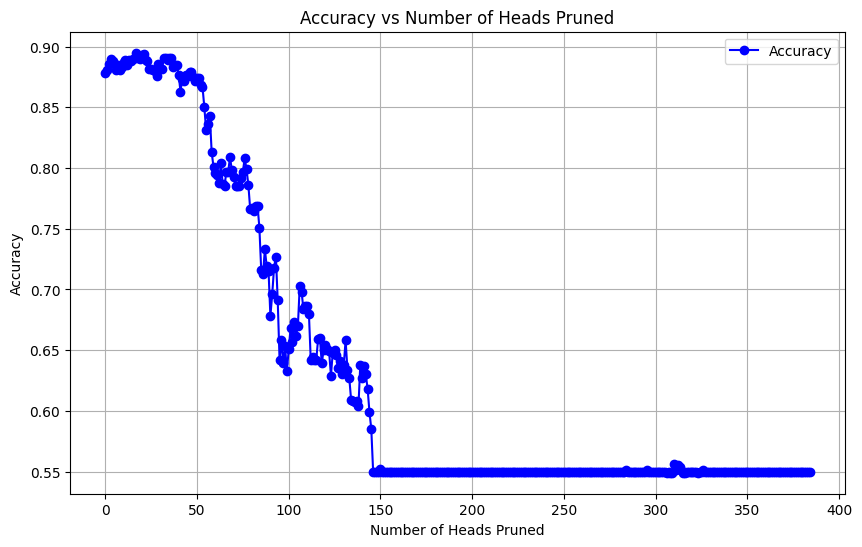

In [4]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(accs_roberta)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, accs_roberta, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [5]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(accs_roberta))),  # 剪掉头的数量
    'Accuracy': accs_roberta
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(ROBERTA)basedonInverseGreedyGnorm.csv', index=False)


# XLM-ROBERTA的Gnorm倒序裁剪

In [1]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
model = AutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection")
ds = load_dataset("papluca/language-identification")

In [3]:
import torch
from tqdm import tqdm
# 扩展一个剪枝后的 tensor 到 768x768
def expand_weights_to_768x768(tensor, pruned_heads):
    # 初始化列表，存储拼接的张量
    tensors_to_concat = []
    start = 0
    # 按照 pruned_heads 进行插入
    for head_idx, keep in enumerate(pruned_heads):
        if keep == 1:
            # 如果该头保留，保留原来的 64x768
            tensors_to_concat.append(tensor[start:start+64, :])
            start += 64  # 每次移动 64 行
        else:
            # 如果该头被剪掉，插入 64x768 的零矩阵
            tensors_to_concat.append(torch.zeros(64, tensor.size(1)).to(tensor.device)) 
    # 将所有部分拼接起来，得到最终的 768x768 张量
    expanded_tensor = torch.cat(tensors_to_concat, dim=0)
    return expanded_tensor
def get_QKV_norm(ds, model, tokenizer, pruned_heads, batch_size=32, device='cuda'):
    model.to(device)
    norms_Q = torch.zeros(12, 12).to(device)
    norms_K = torch.zeros(12, 12).to(device)
    norms_V = torch.zeros(12, 12).to(device)
    all_titles = ds['validation']['text']
    for layer in range(12):
        attention_layer = model.roberta.encoder.layer[layer].attention.self
        heads_Q_weight = attention_layer.query.weight
        heads_K_weight = attention_layer.key.weight
        heads_V_weight = attention_layer.value.weight
        heads_Q_weight = heads_Q_weight.to(device)
        heads_K_weight = heads_K_weight.to(device)
        heads_V_weight = heads_V_weight.to(device)
        for i in range(0, 500, batch_size):
            batch_titles = all_titles[i:i+batch_size]
            inputs = tokenizer(batch_titles, return_tensors='pt', padding=True, truncation=True)
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            sequence_output = outputs.logits
            loss = torch.norm(sequence_output)
            model.zero_grad()
            loss.backward()
            # 处理剪枝后的权重，扩展到 768x768
            GQ  = expand_weights_to_768x768(heads_Q_weight.grad, pruned_heads[layer])
            GK  = expand_weights_to_768x768(heads_K_weight.grad, pruned_heads[layer])
            GV  = expand_weights_to_768x768(heads_V_weight.grad, pruned_heads[layer])
            tensor_Q_reshaped = GQ.view(12, 64, 768)
            tensor_K_reshaped = GK.view(12, 64, 768)
            tensor_V_reshaped = GV.view(12, 64, 768)
            l2_Q_norms = torch.norm(tensor_Q_reshaped, p=2, dim=(1, 2))
            l2_K_norms = torch.norm(tensor_K_reshaped, p=2, dim=(1, 2))
            l2_V_norms = torch.norm(tensor_V_reshaped, p=2, dim=(1, 2))
            norms_Q[layer] += l2_Q_norms
            norms_K[layer] += l2_K_norms
            norms_V[layer] += l2_V_norms
        model.zero_grad()
    norms_Q = norms_Q.cpu() / len(all_titles)
    norms_K = norms_K.cpu() / len(all_titles)
    norms_V = norms_V.cpu() / len(all_titles)
    norms = norms_Q * norms_K * norms_V
    mean_norms = norms.mean()
    std_norms = norms.std()
    normalized = (norms - mean_norms) / std_norms
    return normalized
def get_new_head_mask_basedonG(head_mask_previous,Gnorm):
    selected_matrix = head_mask_previous * (Gnorm)
    if (torch.all(torch.eq(selected_matrix, 0)).item()==True) and (torch.all(torch.eq(head_mask_previous, 0)).item()==False):
        layer = torch.nonzero(head_mask_previous)[0][0]
        head = torch.nonzero(head_mask_previous)[0][1]
        head_mask_previous[layer][head] = 0
        current_head_mask = head_mask_previous
        return current_head_mask
    layer=torch.argmax(selected_matrix) // selected_matrix.size(1)
    head=torch.argmax(selected_matrix) % selected_matrix.size(1)
    print('layer:',layer,'\nhead:',head)
    head_mask_previous[layer][head] = 0
    current_head_mask = head_mask_previous
    return current_head_mask
def get_acc(ds,model,tokenizer,size=len(ds['validation']),device='cuda'):
    count = 0
    id2lang = model.config.id2label
    cursor = 0
    model.to(device)
    for data in ds['validation']:
        cursor += 1
        inputs = tokenizer(data['text'], padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        preds = torch.softmax(logits, dim=-1)
        vals, idx = torch.max(preds, dim=1)
        if id2lang[idx.item()]==data['labels']:
            count += 1
        if cursor > size:
            break
    return count / size
def prune_based_on_G(ds,model,tokenizer):
    head_mask = torch.tensor([[1]*12]*12)
    accs=[]
    pruner = TransformerPruner(model)
    model.to('cuda')
    accs.append(get_acc(ds,model,tokenizer))
    print('pruned heads:',0,'acc:',accs[0])
    for i in tqdm(range(144)):
        Gnorm = get_QKV_norm(ds,model,tokenizer,pruned_heads=head_mask,batch_size=8)
        head_mask = get_new_head_mask_basedonG(head_mask,Gnorm)
        model.to('cuda')
        print('head_mask',head_mask)
        pruner.prune(head_mask=head_mask,save_model=False)
        acc_score = get_acc(ds,model,tokenizer,size=3000)
        accs.append(acc_score)
        print('pruned heads:',i+1,'acc:',acc_score)
    return accs

In [4]:
accs_xlm_roberta = prune_based_on_G(ds,model,tokenizer)

pruned heads: 0 acc: 0.9973


  0%|          | 0/144 [00:00<?, ?it/s]

layer: tensor(10) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


  1%|          | 1/144 [00:33<1:18:43, 33.03s/it]

pruned heads: 1 acc: 0.9983333333333333
layer: tensor(11) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  1%|▏         | 2/144 [01:07<1:20:43, 34.11s/it]

pruned heads: 2 acc: 0.9983333333333333
layer: tensor(10) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  2%|▏         | 3/144 [01:42<1:20:41, 34.34s/it]

pruned heads: 3 acc: 0.9983333333333333
layer: tensor(5) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  3%|▎         | 4/144 [02:18<1:21:35, 34.96s/it]

pruned heads: 4 acc: 0.997
layer: tensor(2) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  3%|▎         | 5/144 [02:55<1:22:48, 35.74s/it]

pruned heads: 5 acc: 0.995
layer: tensor(9) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  4%|▍         | 6/144 [03:31<1:22:16, 35.77s/it]

pruned heads: 6 acc: 0.963
layer: tensor(7) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  5%|▍         | 7/144 [04:07<1:22:04, 35.94s/it]

pruned heads: 7 acc: 0.934
layer: tensor(1) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  6%|▌         | 8/144 [04:44<1:21:53, 36.13s/it]

pruned heads: 8 acc: 0.931
layer: tensor(6) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  6%|▋         | 9/144 [05:20<1:21:29, 36.22s/it]

pruned heads: 9 acc: 0.9383333333333334
layer: tensor(5) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  7%|▋         | 10/144 [05:56<1:20:56, 36.24s/it]

pruned heads: 10 acc: 0.903
layer: tensor(4) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  8%|▊         | 11/144 [06:33<1:20:35, 36.36s/it]

pruned heads: 11 acc: 0.786
layer: tensor(6) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  8%|▊         | 12/144 [07:10<1:20:23, 36.54s/it]

pruned heads: 12 acc: 0.7906666666666666
layer: tensor(4) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


  9%|▉         | 13/144 [07:47<1:19:57, 36.63s/it]

pruned heads: 13 acc: 0.7806666666666666
layer: tensor(3) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 10%|▉         | 14/144 [08:23<1:19:09, 36.54s/it]

pruned heads: 14 acc: 0.77
layer: tensor(4) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 10%|█         | 15/144 [09:01<1:19:18, 36.89s/it]

pruned heads: 15 acc: 0.7696666666666667
layer: tensor(6) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 11%|█         | 16/144 [09:37<1:18:29, 36.80s/it]

pruned heads: 16 acc: 0.7553333333333333
layer: tensor(4) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 12%|█▏        | 17/144 [10:14<1:18:00, 36.86s/it]

pruned heads: 17 acc: 0.7586666666666667
layer: tensor(7) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 12%|█▎        | 18/144 [10:52<1:17:37, 36.97s/it]

pruned heads: 18 acc: 0.7676666666666667
layer: tensor(3) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 13%|█▎        | 19/144 [11:28<1:16:31, 36.74s/it]

pruned heads: 19 acc: 0.7676666666666667
layer: tensor(10) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 14%|█▍        | 20/144 [12:04<1:15:38, 36.60s/it]

pruned heads: 20 acc: 0.8003333333333333
layer: tensor(7) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 15%|█▍        | 21/144 [12:41<1:15:11, 36.68s/it]

pruned heads: 21 acc: 0.8053333333333333
layer: tensor(9) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 15%|█▌        | 22/144 [13:17<1:14:26, 36.61s/it]

pruned heads: 22 acc: 0.7993333333333333
layer: tensor(9) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 16%|█▌        | 23/144 [13:54<1:13:49, 36.61s/it]

pruned heads: 23 acc: 0.7936666666666666
layer: tensor(4) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 17%|█▋        | 24/144 [14:30<1:13:05, 36.54s/it]

pruned heads: 24 acc: 0.802
layer: tensor(3) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 17%|█▋        | 25/144 [15:08<1:13:21, 36.98s/it]

pruned heads: 25 acc: 0.8053333333333333
layer: tensor(3) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 18%|█▊        | 26/144 [15:45<1:12:41, 36.96s/it]

pruned heads: 26 acc: 0.802
layer: tensor(2) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 19%|█▉        | 27/144 [16:23<1:12:37, 37.25s/it]

pruned heads: 27 acc: 0.7903333333333333
layer: tensor(6) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 19%|█▉        | 28/144 [17:00<1:11:54, 37.19s/it]

pruned heads: 28 acc: 0.7786666666666666
layer: tensor(6) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 20%|██        | 29/144 [17:37<1:10:51, 36.97s/it]

pruned heads: 29 acc: 0.7836666666666666
layer: tensor(3) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 21%|██        | 30/144 [18:13<1:09:50, 36.76s/it]

pruned heads: 30 acc: 0.7846666666666666
layer: tensor(2) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 22%|██▏       | 31/144 [18:50<1:09:23, 36.84s/it]

pruned heads: 31 acc: 0.7333333333333333
layer: tensor(4) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 22%|██▏       | 32/144 [19:26<1:08:09, 36.51s/it]

pruned heads: 32 acc: 0.708
layer: tensor(1) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 23%|██▎       | 33/144 [20:02<1:07:22, 36.42s/it]

pruned heads: 33 acc: 0.6993333333333334
layer: tensor(8) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 24%|██▎       | 34/144 [20:39<1:06:51, 36.47s/it]

pruned heads: 34 acc: 0.7466666666666667
layer: tensor(5) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 24%|██▍       | 35/144 [21:15<1:06:07, 36.40s/it]

pruned heads: 35 acc: 0.7386666666666667
layer: tensor(3) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 25%|██▌       | 36/144 [21:51<1:05:34, 36.43s/it]

pruned heads: 36 acc: 0.731
layer: tensor(2) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 26%|██▌       | 37/144 [22:28<1:05:02, 36.47s/it]

pruned heads: 37 acc: 0.7116666666666667
layer: tensor(6) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 26%|██▋       | 38/144 [23:05<1:04:36, 36.57s/it]

pruned heads: 38 acc: 0.7083333333333334
layer: tensor(7) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 27%|██▋       | 39/144 [23:41<1:03:41, 36.39s/it]

pruned heads: 39 acc: 0.7336666666666667
layer: tensor(11) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 28%|██▊       | 40/144 [24:18<1:03:18, 36.53s/it]

pruned heads: 40 acc: 0.6823333333333333
layer: tensor(9) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 28%|██▊       | 41/144 [24:54<1:02:51, 36.61s/it]

pruned heads: 41 acc: 0.668
layer: tensor(9) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 29%|██▉       | 42/144 [25:30<1:01:45, 36.33s/it]

pruned heads: 42 acc: 0.7353333333333333
layer: tensor(10) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 30%|██▉       | 43/144 [26:06<1:01:12, 36.36s/it]

pruned heads: 43 acc: 0.6773333333333333
layer: tensor(10) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 31%|███       | 44/144 [26:43<1:00:55, 36.55s/it]

pruned heads: 44 acc: 0.6813333333333333
layer: tensor(10) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 31%|███▏      | 45/144 [27:21<1:00:42, 36.79s/it]

pruned heads: 45 acc: 0.6643333333333333
layer: tensor(10) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]])


 32%|███▏      | 46/144 [27:57<59:37, 36.51s/it]  

pruned heads: 46 acc: 0.51
layer: tensor(11) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]])


 33%|███▎      | 47/144 [28:33<58:47, 36.36s/it]

pruned heads: 47 acc: 0.306
layer: tensor(3) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]])


 33%|███▎      | 48/144 [29:09<58:07, 36.32s/it]

pruned heads: 48 acc: 0.14233333333333334
layer: tensor(8) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]])


 34%|███▍      | 49/144 [29:45<57:16, 36.17s/it]

pruned heads: 49 acc: 0.12866666666666668
layer: tensor(11) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]])


 35%|███▍      | 50/144 [30:21<56:33, 36.11s/it]

pruned heads: 50 acc: 0.11566666666666667
layer: tensor(11) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]])


 35%|███▌      | 51/144 [30:57<56:11, 36.26s/it]

pruned heads: 51 acc: 0.076
layer: tensor(11) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]])


 36%|███▌      | 52/144 [31:33<55:12, 36.01s/it]

pruned heads: 52 acc: 0.052
layer: tensor(11) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]])


 37%|███▋      | 53/144 [32:09<54:34, 35.98s/it]

pruned heads: 53 acc: 0.052
layer: tensor(11) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]])


 38%|███▊      | 54/144 [32:45<54:04, 36.05s/it]

pruned heads: 54 acc: 0.052
layer: tensor(11) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])


 38%|███▊      | 55/144 [33:21<53:34, 36.12s/it]

pruned heads: 55 acc: 0.052
layer: tensor(11) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


 39%|███▉      | 56/144 [33:58<53:20, 36.36s/it]

pruned heads: 56 acc: 0.052
layer: tensor(11) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 40%|███▉      | 57/144 [34:35<52:52, 36.47s/it]

pruned heads: 57 acc: 0.052
layer: tensor(11) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
 40%|████      | 58/144 [35:10<51:47, 36.13s/it]

pruned heads: 58 acc: 0.052
layer: tensor(10) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 41%|████      | 59/144 [35:45<50:40, 35.77s/it]

pruned heads: 59 acc: 0.052
layer: tensor(10) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 42%|████▏     | 60/144 [36:21<50:02, 35.75s/it]

pruned heads: 60 acc: 0.052
layer: tensor(10) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 42%|████▏     | 61/144 [36:57<49:45, 35.97s/it]

pruned heads: 61 acc: 0.052
layer: tensor(10) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 43%|████▎     | 62/144 [37:32<48:40, 35.62s/it]

pruned heads: 62 acc: 0.052
layer: tensor(10) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 44%|████▍     | 63/144 [38:07<47:41, 35.33s/it]

pruned heads: 63 acc: 0.052
layer: tensor(9) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 44%|████▍     | 64/144 [38:41<46:36, 34.96s/it]

pruned heads: 64 acc: 0.052
layer: tensor(9) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 45%|████▌     | 65/144 [39:15<45:50, 34.82s/it]

pruned heads: 65 acc: 0.052
layer: tensor(9) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 46%|████▌     | 66/144 [39:50<45:11, 34.76s/it]

pruned heads: 66 acc: 0.052
layer: tensor(8) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 47%|████▋     | 67/144 [40:25<44:34, 34.74s/it]

pruned heads: 67 acc: 0.052
layer: tensor(9) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 47%|████▋     | 68/144 [41:00<44:08, 34.85s/it]

pruned heads: 68 acc: 0.052
layer: tensor(9) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 48%|████▊     | 69/144 [41:34<43:20, 34.67s/it]

pruned heads: 69 acc: 0.052
layer: tensor(8) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 49%|████▊     | 70/144 [42:08<42:27, 34.42s/it]

pruned heads: 70 acc: 0.052
layer: tensor(7) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 49%|████▉     | 71/144 [42:42<41:53, 34.43s/it]

pruned heads: 71 acc: 0.052
layer: tensor(5) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 50%|█████     | 72/144 [43:16<41:11, 34.32s/it]

pruned heads: 72 acc: 0.052
layer: tensor(8) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 51%|█████     | 73/144 [43:50<40:32, 34.26s/it]

pruned heads: 73 acc: 0.052
layer: tensor(9) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 51%|█████▏    | 74/144 [44:25<39:54, 34.21s/it]

pruned heads: 74 acc: 0.052
layer: tensor(6) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 52%|█████▏    | 75/144 [44:58<39:10, 34.06s/it]

pruned heads: 75 acc: 0.052
layer: tensor(8) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 53%|█████▎    | 76/144 [45:31<38:08, 33.66s/it]

pruned heads: 76 acc: 0.052
layer: tensor(6) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 53%|█████▎    | 77/144 [46:05<37:45, 33.81s/it]

pruned heads: 77 acc: 0.052
layer: tensor(8) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 54%|█████▍    | 78/144 [46:38<36:58, 33.62s/it]

pruned heads: 78 acc: 0.052
layer: tensor(7) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 55%|█████▍    | 79/144 [47:11<36:05, 33.31s/it]

pruned heads: 79 acc: 0.052
layer: tensor(8) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 56%|█████▌    | 80/144 [47:43<35:15, 33.05s/it]

pruned heads: 80 acc: 0.052
layer: tensor(6) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 56%|█████▋    | 81/144 [48:16<34:38, 32.99s/it]

pruned heads: 81 acc: 0.052
layer: tensor(7) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 57%|█████▋    | 82/144 [48:49<34:06, 33.01s/it]

pruned heads: 82 acc: 0.052
layer: tensor(5) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 58%|█████▊    | 83/144 [49:22<33:21, 32.81s/it]

pruned heads: 83 acc: 0.052
layer: tensor(7) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 58%|█████▊    | 84/144 [49:54<32:41, 32.69s/it]

pruned heads: 84 acc: 0.052
layer: tensor(7) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 59%|█████▉    | 85/144 [50:27<32:22, 32.93s/it]

pruned heads: 85 acc: 0.052
layer: tensor(7) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 60%|█████▉    | 86/144 [51:01<32:05, 33.20s/it]

pruned heads: 86 acc: 0.052
layer: tensor(7) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 60%|██████    | 87/144 [51:34<31:19, 32.98s/it]

pruned heads: 87 acc: 0.052
layer: tensor(7) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 61%|██████    | 88/144 [52:06<30:34, 32.75s/it]

pruned heads: 88 acc: 0.052
layer: tensor(9) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 62%|██████▏   | 89/144 [52:38<29:45, 32.46s/it]

pruned heads: 89 acc: 0.052
layer: tensor(8) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 62%|██████▎   | 90/144 [53:09<28:53, 32.11s/it]

pruned heads: 90 acc: 0.052
layer: tensor(8) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 63%|██████▎   | 91/144 [53:40<28:09, 31.88s/it]

pruned heads: 91 acc: 0.052
layer: tensor(8) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 64%|██████▍   | 92/144 [54:12<27:37, 31.88s/it]

pruned heads: 92 acc: 0.052
layer: tensor(8) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 65%|██████▍   | 93/144 [54:44<26:58, 31.74s/it]

pruned heads: 93 acc: 0.052
layer: tensor(6) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 65%|██████▌   | 94/144 [55:15<26:21, 31.62s/it]

pruned heads: 94 acc: 0.052
layer: tensor(6) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 66%|██████▌   | 95/144 [55:46<25:41, 31.46s/it]

pruned heads: 95 acc: 0.052
layer: tensor(5) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 67%|██████▋   | 96/144 [56:18<25:13, 31.52s/it]

pruned heads: 96 acc: 0.052
layer: tensor(6) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 67%|██████▋   | 97/144 [56:49<24:34, 31.37s/it]

pruned heads: 97 acc: 0.052
layer: tensor(5) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 68%|██████▊   | 98/144 [57:20<23:54, 31.18s/it]

pruned heads: 98 acc: 0.052
layer: tensor(5) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 69%|██████▉   | 99/144 [57:51<23:23, 31.18s/it]

pruned heads: 99 acc: 0.052
layer: tensor(5) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 69%|██████▉   | 100/144 [58:22<22:56, 31.28s/it]

pruned heads: 100 acc: 0.052
layer: tensor(4) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 70%|███████   | 101/144 [58:53<22:24, 31.27s/it]

pruned heads: 101 acc: 0.052
layer: tensor(5) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 71%|███████   | 102/144 [59:24<21:37, 30.89s/it]

pruned heads: 102 acc: 0.052
layer: tensor(4) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 72%|███████▏  | 103/144 [59:53<20:54, 30.61s/it]

pruned heads: 103 acc: 0.052
layer: tensor(5) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 72%|███████▏  | 104/144 [1:00:23<20:15, 30.40s/it]

pruned heads: 104 acc: 0.052
layer: tensor(5) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 73%|███████▎  | 105/144 [1:00:53<19:36, 30.16s/it]

pruned heads: 105 acc: 0.052
layer: tensor(3) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 74%|███████▎  | 106/144 [1:01:22<18:50, 29.74s/it]

pruned heads: 106 acc: 0.052
layer: tensor(3) 
head: tensor(8)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 74%|███████▍  | 107/144 [1:01:53<18:39, 30.25s/it]

pruned heads: 107 acc: 0.052
layer: tensor(4) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 75%|███████▌  | 108/144 [1:02:24<18:14, 30.40s/it]

pruned heads: 108 acc: 0.052
layer: tensor(3) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 76%|███████▌  | 109/144 [1:02:54<17:37, 30.20s/it]

pruned heads: 109 acc: 0.052
layer: tensor(4) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 76%|███████▋  | 110/144 [1:03:22<16:52, 29.77s/it]

pruned heads: 110 acc: 0.052
layer: tensor(3) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 77%|███████▋  | 111/144 [1:04:07<18:52, 34.30s/it]

pruned heads: 111 acc: 0.052
layer: tensor(4) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 78%|███████▊  | 112/144 [1:04:58<20:52, 39.13s/it]

pruned heads: 112 acc: 0.052
layer: tensor(3) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 78%|███████▊  | 113/144 [1:05:34<19:50, 38.40s/it]

pruned heads: 113 acc: 0.052
layer: tensor(4) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 79%|███████▉  | 114/144 [1:06:01<17:26, 34.87s/it]

pruned heads: 114 acc: 0.052
layer: tensor(1) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 80%|███████▉  | 115/144 [1:06:28<15:41, 32.48s/it]

pruned heads: 115 acc: 0.052
layer: tensor(1) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 81%|████████  | 116/144 [1:06:55<14:21, 30.77s/it]

pruned heads: 116 acc: 0.052
layer: tensor(2) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 81%|████████▏ | 117/144 [1:07:22<13:23, 29.74s/it]

pruned heads: 117 acc: 0.052
layer: tensor(2) 
head: tensor(4)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 82%|████████▏ | 118/144 [1:07:49<12:33, 29.00s/it]

pruned heads: 118 acc: 0.052
layer: tensor(1) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 83%|████████▎ | 119/144 [1:08:16<11:47, 28.32s/it]

pruned heads: 119 acc: 0.052
layer: tensor(1) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 83%|████████▎ | 120/144 [1:08:43<11:11, 27.98s/it]

pruned heads: 120 acc: 0.052
layer: tensor(2) 
head: tensor(5)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 84%|████████▍ | 121/144 [1:09:12<10:48, 28.20s/it]

pruned heads: 121 acc: 0.052
layer: tensor(2) 
head: tensor(2)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 85%|████████▍ | 122/144 [1:09:40<10:20, 28.22s/it]

pruned heads: 122 acc: 0.052
layer: tensor(2) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 85%|████████▌ | 123/144 [1:10:08<09:51, 28.18s/it]

pruned heads: 123 acc: 0.052
layer: tensor(2) 
head: tensor(1)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 86%|████████▌ | 124/144 [1:10:37<09:28, 28.42s/it]

pruned heads: 124 acc: 0.052
layer: tensor(1) 
head: tensor(3)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 87%|████████▋ | 125/144 [1:11:11<09:27, 29.88s/it]

pruned heads: 125 acc: 0.052
layer: tensor(2) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 88%|████████▊ | 126/144 [1:11:47<09:34, 31.89s/it]

pruned heads: 126 acc: 0.052
layer: tensor(1) 
head: tensor(11)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 88%|████████▊ | 127/144 [1:12:37<10:31, 37.13s/it]

pruned heads: 127 acc: 0.052
layer: tensor(1) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 89%|████████▉ | 128/144 [1:13:05<09:13, 34.57s/it]

pruned heads: 128 acc: 0.052
layer: tensor(1) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 90%|████████▉ | 129/144 [1:13:32<08:05, 32.35s/it]

pruned heads: 129 acc: 0.052
layer: tensor(0) 
head: tensor(9)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 90%|█████████ | 130/144 [1:14:00<07:13, 30.95s/it]

pruned heads: 130 acc: 0.052
layer: tensor(1) 
head: tensor(0)
head_mask tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 91%|█████████ | 131/144 [1:14:28<06:29, 29.93s/it]

pruned heads: 131 acc: 0.052
layer: tensor(0) 
head: tensor(6)
head_mask tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 132/144 [1:15:05<06:27, 32.30s/it]

pruned heads: 132 acc: 0.052
layer: tensor(2) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 92%|█████████▏| 133/144 [1:15:55<06:51, 37.43s/it]

pruned heads: 133 acc: 0.052
layer: tensor(1) 
head: tensor(10)
head_mask tensor([[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 93%|█████████▎| 134/144 [1:16:24<05:50, 35.09s/it]

pruned heads: 134 acc: 0.052
layer: tensor(0) 
head: tensor(7)
head_mask tensor([[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 94%|█████████▍| 135/144 [1:16:52<04:56, 33.00s/it]

pruned heads: 135 acc: 0.052
layer: tensor(0) 
head: tensor(2)
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 94%|█████████▍| 136/144 [1:17:21<04:13, 31.66s/it]

pruned heads: 136 acc: 0.052
layer: tensor(0) 
head: tensor(11)
head_mask tensor([[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 95%|█████████▌| 137/144 [1:18:06<04:09, 35.65s/it]

pruned heads: 137 acc: 0.052
layer: tensor(0) 
head: tensor(4)
head_mask tensor([[1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 96%|█████████▌| 138/144 [1:18:47<03:44, 37.34s/it]

pruned heads: 138 acc: 0.052
layer: tensor(0) 
head: tensor(1)
head_mask tensor([[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 139/144 [1:19:20<02:59, 35.86s/it]

pruned heads: 139 acc: 0.052
layer: tensor(0) 
head: tensor(0)
head_mask tensor([[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 97%|█████████▋| 140/144 [1:19:46<02:11, 32.89s/it]

pruned heads: 140 acc: 0.052
layer: tensor(0) 
head: tensor(10)
head_mask tensor([[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 98%|█████████▊| 141/144 [1:20:12<01:32, 30.81s/it]

pruned heads: 141 acc: 0.052
layer: tensor(0) 
head: tensor(5)
head_mask tensor([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▊| 142/144 [1:20:38<00:58, 29.38s/it]

pruned heads: 142 acc: 0.052
layer: tensor(0) 
head: tensor(8)
head_mask tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


 99%|█████████▉| 143/144 [1:21:10<00:30, 30.15s/it]

pruned heads: 143 acc: 0.052
layer: tensor(0) 
head: tensor(3)
head_mask tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


100%|██████████| 144/144 [1:21:38<00:00, 34.02s/it]

pruned heads: 144 acc: 0.052


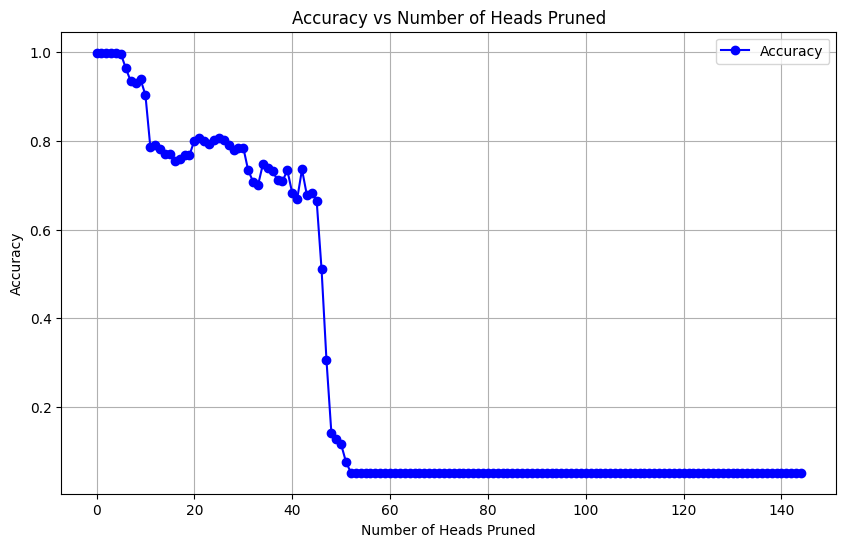

In [5]:
import matplotlib.pyplot as plt

# 假设你已经有剪头后的准确率 accs 列表
# accs 是你剪掉不同数量的头时的准确率，如 [0.90, 0.88, 0.85, ..., 0.70]
# 横坐标表示剪掉的头的数量，从 0 到剪掉头的总数
num_heads_pruned = list(range(len(accs_xlm_roberta)))

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制剪掉头数量与准确率的关系曲线
plt.plot(num_heads_pruned, accs_xlm_roberta, marker='o', linestyle='-', color='b', label='Accuracy')

# 添加标题和标签
plt.title("Accuracy vs Number of Heads Pruned")
plt.xlabel("Number of Heads Pruned")
plt.ylabel("Accuracy")

# 添加网格和图例
plt.grid(True)
plt.legend()

# 显示图表
plt.show()


In [6]:
import pandas as pd

# 假设 accs 是你已经计算好的准确率列表
# 例如：accs = [0.90, 0.88, 0.85, ...]

# 将准确率列表保存到 Pandas DataFrame 中
accs_df = pd.DataFrame({
    'Pruned_Heads': list(range(len(accs_xlm_roberta))),  # 剪掉头的数量
    'Accuracy': accs_xlm_roberta
})

# 将数据保存到 CSV 文件中
accs_df.to_csv('pruned_heads_accuracy(XLM_ROBERTA)basedonInverseGreedyGnorm.csv', index=False)
